In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
from tqdm.auto import tqdm
from scipy.interpolate import interp1d
import heartpy as hp
import tables
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from itertools import product
from matplotlib import cm
import tikzplotlib
import matplotlib as mpl
from skimage.transform import resize
import neurokit2 as nk

INPUT_DATA_PATH = './resampled_data/'

/home/quentin/python-env/python-latest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.reset_orig()
plt.style.use('seaborn-paper')

In [3]:
mpl.rcParams.update({"axes.grid" : True})

## Prepare data

In [4]:
model_file = ""
for enum_ind, file_or_dir in enumerate(listdir(INPUT_DATA_PATH)):
    if file_or_dir.endswith('model_data.pkl'):
        model_file = file_or_dir
        break

In [5]:
if model_file == "":
    dataframe = {'UserID': [], 'VideoID': [], 'TimeStamp': [], 'Frame': [], 'EDA': [], 'HeartRate': [], 'GazeX': [], 'GazeY' :[], 'GazeZ': [], 'HeadX': [], 'HeadY': [], 'HeadZ': []}

    list_of_dirs = listdir(INPUT_DATA_PATH)
    for enum_usr, user_dir in enumerate(sorted(list_of_dirs)):
        try:
            assert user_dir[:5] == 'user_'
            user_id = user_dir.split('_')[-1]
            assert 0 < int(user_id) < 35
        except:
            continue
        print(f'{enum_usr}: {user_id}')

        list_dir_videos = listdir(join(INPUT_DATA_PATH, user_dir))
        skin_data_file = ""
        search_in_file = "shimmer"
        for user_file in list_dir_videos:
            if search_in_file in user_file and user_file.endswith('.csv'):
                skin_data_file = user_file

        if skin_data_file != "":
            df_skin = pd.read_csv(join(INPUT_DATA_PATH, user_dir, skin_data_file))
            skin_timestamps = df_skin['Shimmer_4BCA_Timestamp_Unix_CAL'].values.astype(np.int64)
            skin_conductance = df_skin['Shimmer_4BCA_GSR_Skin_Conductance_CAL'].values.astype(np.float64)
            # Compute EDA
            signals, info = nk.eda_process(skin_conductance, sampling_rate=100.0)
            phasic_eda = signals['EDA_Phasic']
            eda = abs(np.gradient(phasic_eda)).astype(np.float64)
            # Compute heart rate
            ppg_signal = hp.scale_data(df_skin['Shimmer_4BCA_PPG_A13_CAL'].values.astype(np.float64).clip(1350, 1450))
            _, measures = hp.process_segmentwise(ppg_signal, sample_rate=100.0, segment_width=5, segment_overlap=0.5, mode='full')
            bpm_x = [np.mean(bounds) for bounds in measures['segment_indices']]
            bpm_y = measures['bpm']
            # Remove nan and outliers
            to_remove = np.where((np.array(bpm_y) > 180) | np.isnan(bpm_y))[0]
            for idx in reversed(to_remove):
                del bpm_x[idx]
                del bpm_y[idx]
            bpm_x = np.array(bpm_x).astype(np.int64) * 10 + skin_timestamps.min()
            # Resample
            xnew = skin_timestamps
            f = interp1d(bpm_x, bpm_y, bounds_error=False, fill_value=(bpm_y[0], bpm_y[-1]))
            heartrate = f(xnew)

            start_gsr = skin_timestamps.min()
            end_gsr = skin_timestamps.max()

            for enum_vids, f in enumerate(list_dir_videos):
                if f.endswith('.csv') and "shimmer" not in f:

                    video_id = f.split('_')[1][:-4]

                    print(user_id, video_id)

                    df_gaze = pd.read_csv(join(INPUT_DATA_PATH, user_dir, f))

                    gaze_timestamps = df_gaze['time'].values.astype(np.int64)
                    frames = df_gaze['frame'].values.astype(np.int32)

                    gazeX = df_gaze['gaze_x'].values.astype(np.float64)
                    gazeY = df_gaze['gaze_y'].values.astype(np.float64)
                    gazeZ = df_gaze['gaze_z'].values.astype(np.float64)

                    headX = df_gaze['head_x'].values.astype(np.float64)
                    headY = df_gaze['head_y'].values.astype(np.float64)
                    headZ = df_gaze['head_z'].values.astype(np.float64)

                    start_gaze = gaze_timestamps.min()
                    aligned_start = max(start_gsr, start_gaze)

                    end_gaze = gaze_timestamps.max()
                    aligned_end = min(end_gsr, end_gaze)

                    gsr_start_index = np.where(skin_timestamps == aligned_start)[0][0]
                    gaze_start_index = np.where(gaze_timestamps == aligned_start)[0][0]
                    gsr_end_index = np.where(skin_timestamps == aligned_end)[0][0]
                    gaze_end_index = np.where(gaze_timestamps == aligned_end)[0][0]

                    assert np.all(gaze_timestamps[gaze_start_index:gaze_end_index] == skin_timestamps[gsr_start_index:gsr_end_index])

                    dataframe['UserID'].extend([user_id] * (gsr_end_index - gsr_start_index))
                    dataframe['VideoID'].extend([video_id] * (gsr_end_index - gsr_start_index))

                    dataframe['TimeStamp'].extend(gaze_timestamps[gaze_start_index:gaze_end_index])
                    dataframe['Frame'].extend(frames[gaze_start_index:gaze_end_index])

                    dataframe['EDA'].extend(eda[gsr_start_index:gsr_end_index])
                    dataframe['HeartRate'].extend(heartrate[gsr_start_index:gsr_end_index])

                    dataframe['GazeX'].extend(gazeX[gaze_start_index:gaze_end_index])
                    dataframe['GazeY'].extend(gazeY[gaze_start_index:gaze_end_index])
                    dataframe['GazeZ'].extend(gazeZ[gaze_start_index:gaze_end_index])
                    dataframe['HeadX'].extend(headX[gaze_start_index:gaze_end_index])
                    dataframe['HeadY'].extend(headY[gaze_start_index:gaze_end_index])
                    dataframe['HeadZ'].extend(headZ[gaze_start_index:gaze_end_index])

    print("Finished loading data")

    model_data = pd.DataFrame(data=dataframe)
    model_data.to_pickle(join(INPUT_DATA_PATH, "model_data.pkl"))
else:
    model_data = pd.read_pickle(join(INPUT_DATA_PATH, model_file))

In [6]:
model_data

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2194797     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2194798     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2194799     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2194800     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2194801     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX     HeadY     HeadZ  
0       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
1       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
2       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
3       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
4       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
...           ...       ...       ...       ...       ...  
2194797 -0.995782 -0.019075 -0.271354 -0.962475 -0.002869  
2194798 -0.995953 -0.017002 -0.270827 -0.962623 -0.003116  
2194799 -0.996025 -0.016504 -0.270423 -0.962736 -0.003427  
2194800 -0.996046 -0.016693 -0.270160 -0.962808 -0.003763  
2194801 -0.996055 -0.016899 -0.270032 -0.962843 -0.004097  

[2194802 rows x 12 columns]

In [7]:
df_raw = pd.read_pickle(join(INPUT_DATA_PATH, "model_data.pkl"))

In [8]:
# Remove user 2 and user 14 because of incomplete data
idx = df_raw[(df_raw['UserID']=='02')|(df_raw['UserID']=='14')].index
df_raw = df_raw.drop(index=idx).reset_index(drop=True)

In [9]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX     HeadY     HeadZ  
0       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
1       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
2       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
3       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
4       -0.979322  0.201600 -0.016930 -0.979322  0.201600  
...           ...       ...       ...       ...       ...  
2148706 -0.995782 -0.019075 -0.271354 -0.962475 -0.002869  
2148707 -0.995953 -0.017002 -0.270827 -0.962623 -0.003116  
2148708 -0.996025 -0.016504 -0.270423 -0.962736 -0.003427  
2148709 -0.996046 -0.016693 -0.270160 -0.962808 -0.003763  
2148710 -0.996055 -0.016899 -0.270032 -0.962843 -0.004097  

[2148711 rows x 12 columns]

## Useful functions

In [10]:
def get_valence_arousal(user, video):
    df_plan = pd.read_csv('./design_of_experiments.csv')
    video_index = np.argwhere(df_plan[df_plan['user_id'] == int(user)].values[0, 1:] == int(video)).item()
    
    df_q = pd.read_csv('./graded_valence_arousal.csv')
    cols = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]
    
    video_cols = cols[video_index]
    valence, arousal = df_q[df_q['user_id']==int(user)].values[0, cols[video_index]]
    
    return valence, arousal

In [11]:
SAMPLING_RATE = 100
def get_speed_from_angles(array):
    angular_speed = array * SAMPLING_RATE
    acceleration = abs(np.gradient(angular_speed)) * SAMPLING_RATE
    return angular_speed, acceleration
def get_speed_acc(array):
    array /= np.tile(np.linalg.norm(array, axis=-1), (3, 1)).T
    euclidean_distance = np.linalg.norm(np.gradient(array, axis=0), axis=-1)
    orth_dist = 2 * np.arcsin(euclidean_distance / 2)
    return get_speed_from_angles(orth_dist)
def get_speed_acc_yaw_pitch(array):
    yaw, pitch = cartesian_to_eulerian(array)
    yaw_gradient = abs((np.gradient(yaw, axis=-1) + np.pi) % (2 * np.pi) - np.pi)
    pitch_gradient = abs((np.gradient(pitch, axis=-1) + np.pi) % (2 * np.pi) - np.pi)
    return get_speed_from_angles(yaw_gradient), get_speed_from_angles(pitch_gradient)
def cartesian_to_eulerian(array):
    r = np.linalg.norm(array, axis=-1)
    theta = np.arctan2(array[..., 1], array[..., 0])
    phi = np.arccos(array[..., 2] / r)
    theta = np.remainder(theta, 2 * np.pi, dtype=theta.dtype)
    return theta, phi

In [12]:
def convert_to_quaternions(array):
    L = array.shape[0]
    axes = np.empty((L - 1, 3))
    u = array[:-1] / np.tile(np.linalg.norm(array[:-1], axis=-1), (3, 1)).T
    v = array[1:] / np.tile(np.linalg.norm(array[1:], axis=-1), (3, 1)).T
    colinear_cond = np.max(np.abs(u - v), axis=1) < 1e-4
    any_colinear = np.any(colinear_cond)
    if any_colinear:
        colinear_angle = np.zeros((L - 1, ))
        colinear_axis_x = u[:, 0]
        colinear_axis_y = u[:, 1]
        colinear_axis_z = u[:, 2]
    opposite_cond = np.max(np.abs(u + v), axis=1) < 1e-4
    any_opposite = np.any(opposite_cond)
    if any_opposite:
        opposite_angle = np.full((L - 1, ), np.pi)
        u_x = abs(u[:, 0])
        u_y = abs(u[:, 1])
        u_z = abs(u[:, 2])
        cross_x_cond = (u_x < u_y) & (u_x < u_z)
        cross_y_cond = ~cross_x_cond & (u_y < u_z)
        cross_z_cond = ~cross_x_cond & ~cross_y_cond
        assert np.all(cross_x_cond | cross_y_cond | cross_z_cond)
        assert not np.any(cross_x_cond & cross_y_cond & cross_z_cond)
        cross_x = np.cross(u, [1., 0., 0.])
        cross_xx = cross_x[:, 0]
        cross_xy = cross_x[:, 1]
        cross_xz = cross_x[:, 2]
        cross_y = np.cross(u, [0., 1., 0.])
        cross_yx = cross_y[:, 0]
        cross_yy = cross_y[:, 1]
        cross_yz = cross_y[:, 2]
        cross_z = np.cross(u, [0., 0., 1.])
        cross_zx = cross_z[:, 0]
        cross_zy = cross_z[:, 1]
        cross_zz = cross_z[:, 2]
        idx_cond = (cross_x_cond * 1 + cross_y_cond * 2 + cross_z_cond * 3) - 1
        opposite_axis_x = np.choose(idx_cond, [cross_xx, cross_yx, cross_zx])
        opposite_axis_y = np.choose(idx_cond, [cross_xy, cross_yy, cross_zy])
        opposite_axis_z = np.choose(idx_cond, [cross_xz, cross_yz, cross_zz])
    default_cond = ~colinear_cond & ~opposite_cond
    default_angle = np.arccos(np.clip((u * v).sum(-1), 0.0, 1.0))
    default_axis = np.cross(u, v)
    default_axis_norm = np.linalg.norm(default_axis, axis=-1)
    default_axis_x = default_axis[:, 0] / default_axis_norm
    default_axis_y = default_axis[:, 1] / default_axis_norm
    default_axis_z = default_axis[:, 2] / default_axis_norm
    if any_colinear and any_opposite:
        angles = np.select([colinear_cond, opposite_cond, default_cond], [colinear_angle, opposite_angle, default_angle])
        axes[:, 0] = np.select([colinear_cond, opposite_cond, default_cond], [colinear_axis_x, opposite_axis_x, default_axis_x])
        axes[:, 1] = np.select([colinear_cond, opposite_cond, default_cond], [colinear_axis_y, opposite_axis_y, default_axis_y])
        axes[:, 2] = np.select([colinear_cond, opposite_cond, default_cond], [colinear_axis_z, opposite_axis_z, default_axis_z])
    elif any_colinear:
        angles = np.select([colinear_cond, default_cond], [colinear_angle, default_angle])
        axes[:, 0] = np.select([colinear_cond, default_cond], [colinear_axis_x, default_axis_x])
        axes[:, 1] = np.select([colinear_cond, default_cond], [colinear_axis_y, default_axis_y])
        axes[:, 2] = np.select([colinear_cond, default_cond], [colinear_axis_z, default_axis_z])
    elif any_opposite:
        angles = np.select([opposite_cond, default_cond], [opposite_angle, default_angle])
        axes[:, 0] = np.select([opposite_cond, default_cond], [opposite_axis_x, default_axis_x])
        axes[:, 1] = np.select([opposite_cond, default_cond], [opposite_axis_y, default_axis_y])
        axes[:, 2] = np.select([opposite_cond, default_cond], [opposite_axis_z, default_axis_z])
    else:
        angles = default_angle
        axes[:, 0] = default_axis_x
        axes[:, 1] = default_axis_y
        axes[:, 2] = default_axis_z
    return angles, axes

def angular_speeds(angles):
    return angles * SAMPLING_RATE

def get_movement(angles, axes, mode='axis_only'):
    cosine_distance = 1 - (axes[:-1, :] * axes[1:, :]).sum(-1)
    if mode == 'axis_only':
        mvt = cosine_distance
    elif mode == 'axis_angles':
        mvt = cosine_distance * angles[:-1] * angles[1:]
    elif mode == 'axis_sqrt_angles':
        mvt = cosine_distance * np.sqrt(angles[:-1]) * np.sqrt(angles[1:])
    else:
        raise ValueError(f'Unknown mode: {mode}.')
    return mvt

## Get all necessary variables: EDA_centered, speed, etc

### Graded valence and arousal

In [13]:
graded_valence = {}
graded_arousal = {}

for user in df_raw['UserID'].unique():
    for video in df_raw['VideoID'].unique():
        valence, arousal = get_valence_arousal(user, video)
        graded_valence[(user, video)] = valence
        graded_arousal[(user, video)] = arousal

In [14]:
df_raw['GradedValence'] = df_raw[['UserID', 'VideoID']].apply(lambda x: graded_valence[(x[0], x[1])], axis=1)
df_raw['GradedArousal'] = df_raw[['UserID', 'VideoID']].apply(lambda x: graded_arousal[(x[0], x[1])], axis=1)

In [15]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX     HeadY     HeadZ  GradedValence  \
0       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
1       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
2       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
3       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
4       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
...           ...       ...       ...       ...       ...            ...   
2148706 -0.995782 -0.019075 -0.271354 -0.962475 -0.002869            6.0   
2148707 -0.995953 -0.017002 -0.270827 -0.962623 -0.003116            6.0   
2148708 -0.996025 -0.016504 -0.270423 -0.962736 -0.003427            6.0   
2148709 -0.996046 -0.016693 -0.270160 -0.962808 -0.003763            6.0   
2148710 -0.996055 -0.016899 -0.270032 -0.962843 -0.004097            6.0   

         GradedArousal  
0                  6.0  
1                  6.0  
2                  6.0  
3                  6.0  
4                  6.0  
...                ...  
2148706            5.0  
2148707            5.0  
2148708            5.0  
2148709            5.0  
2148710            5.0  

[2148711 rows x 14 columns]

### Head yaw and absolute pitch

In [16]:
HeadYaw, HeadPitch = cartesian_to_eulerian(np.stack([df_raw['HeadX'].values, df_raw['HeadY'].values, df_raw['HeadZ'].values], -1))
df_raw['HeadYaw'], df_raw['HeadAbsPitch'] = HeadYaw * (180 / np.pi), abs(HeadPitch - (np.pi / 2)) * (180 / np.pi)

In [17]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX     HeadY     HeadZ  GradedValence  \
0       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
1       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
2       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
3       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
4       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
...           ...       ...       ...       ...       ...            ...   
2148706 -0.995782 -0.019075 -0.271354 -0.962475 -0.002869            6.0   
2148707 -0.995953 -0.017002 -0.270827 -0.962623 -0.003116            6.0   
2148708 -0.996025 -0.016504 -0.270423 -0.962736 -0.003427            6.0   
2148709 -0.996046 -0.016693 -0.270160 -0.962808 -0.003763            6.0   
2148710 -0.996055 -0.016899 -0.270032 -0.962843 -0.004097            6.0   

         GradedArousal     HeadYaw  HeadAbsPitch  
0                  6.0  269.009598     11.630557  
1                  6.0  269.009598     11.630557  
2                  6.0  269.009598     11.630557  
3                  6.0  269.009598     11.630557  
4                  6.0  269.009598     11.630557  
...                ...         ...           ...  
2148706            5.0  254.255105      0.164400  
2148707            5.0  254.286429      0.178533  
2148708            5.0  254.310491      0.196349  
2148709            5.0  254.326103      0.215624  
2148710            5.0  254.333709      0.234722  

[2148711 rows x 16 columns]

### Gaze yaw and absolute pitch

In [18]:
GazeYaw, GazePitch = cartesian_to_eulerian(np.stack([df_raw['GazeX'].values, df_raw['GazeY'].values, df_raw['GazeZ'].values], -1))
df_raw['GazeYaw'], df_raw['GazeAbsPitch'] = GazeYaw * (180 / np.pi), abs(GazePitch - (np.pi / 2)) * (180 / np.pi)

In [19]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX     HeadY     HeadZ  GradedValence  \
0       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
1       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
2       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
3       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
4       -0.979322  0.201600 -0.016930 -0.979322  0.201600            8.0   
...           ...       ...       ...       ...       ...            ...   
2148706 -0.995782 -0.019075 -0.271354 -0.962475 -0.002869            6.0   
2148707 -0.995953 -0.017002 -0.270827 -0.962623 -0.003116            6.0   
2148708 -0.996025 -0.016504 -0.270423 -0.962736 -0.003427            6.0   
2148709 -0.996046 -0.016693 -0.270160 -0.962808 -0.003763            6.0   
2148710 -0.996055 -0.016899 -0.270032 -0.962843 -0.004097            6.0   

         GradedArousal     HeadYaw  HeadAbsPitch     GazeYaw  GazeAbsPitch  
0                  6.0  269.009598     11.630557  269.009598     11.630557  
1                  6.0  269.009598     11.630557  269.009598     11.630557  
2                  6.0  269.009598     11.630557  269.009598     11.630557  
3                  6.0  269.009598     11.630557  269.009598     11.630557  
4                  6.0  269.009598     11.630557  269.009598     11.630557  
...                ...         ...           ...         ...           ...  
2148706            5.0  254.255105      0.164400  264.849844      1.093001  
2148707            5.0  254.286429      0.178533  264.936311      0.974193  
2148708            5.0  254.310491      0.196349  264.977419      0.945647  
2148709            5.0  254.326103      0.215624  264.993645      0.956465  
2148710            5.0  254.333709      0.234722  265.001704      0.968303  

[2148711 rows x 18 columns]

### Head speed and acceleration

In [20]:
df_raw['HeadSpeed'], df_raw['HeadAcceleration'] = get_speed_acc(np.stack([df_raw['HeadX'].values, df_raw['HeadY'].values, df_raw['HeadZ'].values], -1))

In [21]:
(df_raw['HeadYawSpeed'], df_raw['HeadYawAcceleration']), (df_raw['HeadPitchSpeed'], df_raw['HeadPitchAcceleration']) = get_speed_acc_yaw_pitch(np.stack([df_raw['HeadX'].values, df_raw['HeadY'].values, df_raw['HeadZ'].values], -1))

In [22]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX  ...     HeadYaw  HeadAbsPitch  \
0       -0.979322  0.201600 -0.016930  ...  269.009598     11.630557   
1       -0.979322  0.201600 -0.016930  ...  269.009598     11.630557   
2       -0.979322  0.201600 -0.016930  ...  269.009598     11.630557   
3       -0.979322  0.201600 -0.016930  ...  269.009598     11.630557   
4       -0.979322  0.201600 -0.016930  ...  269.009598     11.630557   
...           ...       ...       ...  ...         ...           ...   
2148706 -0.995782 -0.019075 -0.271354  ...  254.255105      0.164400   
2148707 -0.995953 -0.017002 -0.270827  ...  254.286429      0.178533   
2148708 -0.996025 -0.016504 -0.270423  ...  254.310491      0.196349   
2148709 -0.996046 -0.016693 -0.270160  ...  254.326103      0.215624   
2148710 -0.996055 -0.016899 -0.270032  ...  254.333709      0.234722   

            GazeYaw  GazeAbsPitch  HeadSpeed  HeadAcceleration  HeadYawSpeed  \
0        269.009598     11.630557   0.000000          0.000000      0.000000   
1        269.009598     11.630557   0.000000          0.000000      0.000000   
2        269.009598     11.630557   0.000000          0.000000      0.000000   
3        269.009598     11.630557   0.000000          0.000000      0.000000   
4        269.009598     11.630557   0.000000          0.000000      0.000000   
...             ...           ...        ...               ...           ...   
2148706  264.849844      1.093001   0.074722          2.052198      0.069968   
2148707  264.936311      0.974193   0.055797          1.366333      0.048333   
2148708  264.977419      0.945647   0.047395          0.832892      0.034622   
2148709  264.993645      0.956465   0.039140          0.575860      0.020262   
2148710  265.001704      0.968303   0.035878          0.326143      0.013276   

         HeadYawAcceleration  HeadPitchSpeed  HeadPitchAcceleration  
0                   0.000000        0.000000               0.000000  
1                   0.000000        0.000000               0.000000  
2                   0.000000        0.000000               0.000000  
3                   0.000000        0.000000               0.000000  
4                   0.000000        0.000000               0.000000  
...                      ...             ...                    ...  
2148706             2.237033        0.026228               0.056442  
2148707             1.767309        0.027880               0.306980  
2148708             1.403521        0.032368               0.280308  
2148709             1.067263        0.033487               0.048180  
2148710             0.698596        0.033331               0.015517  

[2148711 rows x 24 columns]

### Gaze speed and acceleration

In [23]:
df_raw['GazeSpeed'], df_raw['GazeAcceleration'] = get_speed_acc(np.stack([df_raw['GazeX'].values, df_raw['GazeY'].values, df_raw['GazeZ'].values], -1))

In [24]:
(df_raw['GazeYawSpeed'], df_raw['GazeYawAcceleration']), (df_raw['GazePitchSpeed'], df_raw['GazePitchAcceleration']) = get_speed_acc_yaw_pitch(np.stack([df_raw['GazeX'].values, df_raw['GazeY'].values, df_raw['GazeZ'].values], -1))

In [25]:
df_raw

UserID VideoID      TimeStamp  Frame       EDA  HeartRate     GazeX  \
0           01      23  1623318234590      1  0.000374  73.058126 -0.016930   
1           01      23  1623318234600      1  0.000387  73.036072 -0.016930   
2           01      23  1623318234610      1  0.000400  73.014018 -0.016930   
3           01      23  1623318234620      1  0.000414  72.991964 -0.016930   
4           01      23  1623318234630      1  0.000429  72.969911 -0.016930   
...        ...     ...            ...    ...       ...        ...       ...   
2148706     34      12  1634134023310   2937  0.000627  85.835821 -0.089750   
2148707     34      12  1634134023320   2937  0.000604  85.858907 -0.088250   
2148708     34      12  1634134023330   2938  0.000581  85.881992 -0.087536   
2148709     34      12  1634134023340   2938  0.000560  85.905078 -0.087254   
2148710     34      12  1634134023350   2938  0.000542  85.928164 -0.087114   

            GazeY     GazeZ     HeadX  ...  HeadYawSpeed  HeadYawAcceleration  \
0       -0.979322  0.201600 -0.016930  ...      0.000000             0.000000   
1       -0.979322  0.201600 -0.016930  ...      0.000000             0.000000   
2       -0.979322  0.201600 -0.016930  ...      0.000000             0.000000   
3       -0.979322  0.201600 -0.016930  ...      0.000000             0.000000   
4       -0.979322  0.201600 -0.016930  ...      0.000000             0.000000   
...           ...       ...       ...  ...           ...                  ...   
2148706 -0.995782 -0.019075 -0.271354  ...      0.069968             2.237033   
2148707 -0.995953 -0.017002 -0.270827  ...      0.048333             1.767309   
2148708 -0.996025 -0.016504 -0.270423  ...      0.034622             1.403521   
2148709 -0.996046 -0.016693 -0.270160  ...      0.020262             1.067263   
2148710 -0.996055 -0.016899 -0.270032  ...      0.013276             0.698596   

         HeadPitchSpeed  HeadPitchAcceleration  GazeSpeed  GazeAcceleration  \
0              0.000000               0.000000   0.000000          0.000000   
1              0.000000               0.000000   0.000000          0.000000   
2              0.000000               0.000000   0.000000          0.000000   
3              0.000000               0.000000   0.000000          0.000000   
4              0.000000               0.000000   0.000000          0.000000   
...                 ...                    ...        ...               ...   
2148706        0.026228               0.056442   0.364851         12.946666   
2148707        0.027880               0.306980   0.170076         15.624353   
2148708        0.032368               0.280308   0.052364          7.054777   
2148709        0.033487               0.048180   0.028981          1.368514   
2148710        0.033331               0.015517   0.024994          0.398729   

         GazeYawSpeed  GazeYawAcceleration  GazePitchSpeed  \
0            0.000000             0.000000        0.000000   
1            0.000000             0.000000        0.000000   
2            0.000000             0.000000        0.000000   
3            0.000000             0.000000        0.000000   
4            0.000000             0.000000        0.000000   
...               ...                  ...             ...   
2148706      0.169619             3.551902        0.323045   
2148707      0.111330             5.979285        0.128591   
2148708      0.050033             4.506902        0.015471   
2148709      0.021192             1.798424        0.019771   
2148710      0.014065             0.712722        0.020662   

         GazePitchAcceleration  
0                     0.000000  
1                     0.000000  
2                     0.000000  
3                     0.000000  
4                     0.000000  
...                        ...  
2148706              12.987586  
2148707              15.378693  
2148708               5.440955  
2148709               0.259553  
2148710               0.08904

### Group by (user, video)

In [26]:
df_uv_mean = df_raw.drop(columns=['TimeStamp', 'Frame', 'HeadX', 'HeadY', 'HeadZ', 'GazeX', 'GazeY', 'GazeZ']).groupby(['UserID', 'VideoID'], as_index=False).mean()

In [27]:
df_uv_mean

UserID VideoID       EDA  HeartRate  GradedValence  GradedArousal  \
0       01      12  0.000149  76.139993            8.0            7.0   
1       01      13  0.000078  77.365700            6.0            2.0   
2       01      17  0.000118  85.651488            6.0            3.0   
3       01      23  0.000113  75.937020            8.0            6.0   
4       01      27  0.000207  77.565014            5.0            1.0   
..     ...     ...       ...        ...            ...            ...   
212     34      17  0.000254  87.325591            6.0            6.0   
213     34      23  0.000372  93.420903            7.0            5.0   
214     34      27  0.000105  90.478693            5.0            2.0   
215     34      32  0.000231  91.773292            6.0            2.0   
216     34      73  0.000516  85.155583            5.0            6.0   

        HeadYaw  HeadAbsPitch     GazeYaw  GazeAbsPitch  ...  HeadYawSpeed  \
0    200.334216     12.533380  195.060157     15.658934  ...      1.006904   
1    180.554463     11.999280  181.043467     12.972233  ...      0.985903   
2    198.445222      8.010554  194.740919     14.091119  ...      1.055269   
3    192.532561     13.860627  190.275221     15.595898  ...      1.015822   
4    237.940620     13.773633  236.753360      8.019719  ...      1.166947   
..          ...           ...         ...           ...  ...           ...   
212  210.086672     12.781764  207.421257     15.202732  ...      0.746571   
213  224.941260     14.049283  220.327132     16.639276  ...      1.454843   
214  184.762561      8.567427  179.237374      9.665836  ...      0.907969   
215  222.065427      8.132271  222.293921      8.184340  ...      1.096143   
216  243.561365     15.274373  234.911092     18.571126  ...      1.263875   

     HeadYawAcceleration  HeadPitchSpeed  HeadPitchAcceleration  GazeSpeed  \
0              31.401402        0.219161               2.307052   1.276415   
1              53.889570        0.118793               1.582092   0.979259   
2              45.038294        0.167557               1.968725   1.060658   
3              42.250771        0.199528               1.844157   1.073219   
4              76.766735        0.119843               1.567440   0.798379   
..                   ...             ...                    ...        ...   
212            24.700028        0.246926               2.376849   0.990172   
213            97.460189        0.206298               2.234502   0.925175   
214            54.878643        0.129948               1.353468   0.693127   
215            61.348831        0.147253               2.030184   0.858860   
216            86.809574        0.172802               1.854228   0.793516   

     GazeAcceleration  GazeYawSpeed  GazeYawAcceleration  GazePitchSpeed  \
0           47.411395      1.511098            81.560437        0.495361   
1           42.491646      1.395415            93.236538        0.392839   
2           43.023247      1.490811            90.799839        0.408199   
3           45.666271      1.914383           130.999454        0.435550   
4           35.297554      1.841264           143.761610        0.246793   
..                ...           ...                  ...             ...   
212         34.474489      0.992713            47.337860        0.477577   
213         38.947972      1.882108           142.175118        0.409971   
214         27.314611      1.330275            96.042957        0.280462   
215         32.765575      1.601764           113.078380        0.277444   
216         28.496688      1.877632           145.857587        0.376170   

     GazePitchAcceleration  
0                20.745899  
1                18.881527  
2                18.595974  
3                20.027414  
4                12.104447  
..                     ...  
212              19.403038  
213              19.497314  
214              12.555679  
215              12.127716  
216              15.8

In [28]:
df_uv_std = df_raw.drop(columns=['TimeStamp', 'Frame', 'HeadX', 'HeadY', 'HeadZ', 'GazeX', 'GazeY', 'GazeZ']).groupby(['UserID', 'VideoID'], as_index=False).std()

In [29]:
df_uv_std

UserID VideoID       EDA  HeartRate  GradedValence  GradedArousal  \
0       01      12  0.000215   2.294945            0.0            0.0   
1       01      13  0.000133   9.507676            0.0            0.0   
2       01      17  0.000187  19.363261            0.0            0.0   
3       01      23  0.000220   2.998478            0.0            0.0   
4       01      27  0.000342   3.424172            0.0            0.0   
..     ...     ...       ...        ...            ...            ...   
212     34      17  0.000396   6.288597            0.0            0.0   
213     34      23  0.000558  11.691834            0.0            0.0   
214     34      27  0.000124   6.692236            0.0            0.0   
215     34      32  0.000300   7.709107            0.0            0.0   
216     34      73  0.000531   5.015023            0.0            0.0   

        HeadYaw  HeadAbsPitch     GazeYaw  GazeAbsPitch  ...  HeadYawSpeed  \
0     69.775068     12.513184   73.205761     17.262102  ...      8.948917   
1     77.490325     12.142137   76.523107     16.903098  ...     12.453418   
2     74.503432      8.804578   76.197659     13.112422  ...     11.066695   
3     98.940019     11.597009  102.728523     16.860797  ...     10.817280   
4    112.716806      6.844602  110.357081     12.065124  ...     15.055216   
..          ...           ...         ...           ...  ...           ...   
212   67.375639     11.436640   71.091912     15.425771  ...      7.911891   
213  112.294781     12.262850  113.148463     15.773908  ...     17.061115   
214  121.318043      9.978712  119.928573     15.518536  ...     12.756214   
215   85.899901     10.655505   87.497936     13.875065  ...     13.284710   
216  101.851184      8.136670  107.138642     12.537100  ...     16.130990   

     HeadYawAcceleration  HeadPitchSpeed  HeadPitchAcceleration  GazeSpeed  \
0             626.593807        0.358038              12.261093   2.473436   
1             876.564713        0.376047              22.480979   2.268998   
2             774.797425        0.263194              10.123280   2.662734   
3             760.359327        0.306569               4.106141   2.391732   
4            1055.136117        0.379829              22.221807   2.183525   
..                   ...             ...                    ...        ...   
212           555.129512        0.323440               8.513774   2.194154   
213          1201.533359        0.389867              21.857525   2.112240   
214           897.559416        0.211319               2.779845   1.710267   
215           936.915693        0.432284              27.038774   2.200425   
216          1137.559734        0.244050               7.758054   1.813442   

     GazeAcceleration  GazeYawSpeed  GazeYawAcceleration  GazePitchSpeed  \
0          103.441061     10.955870           750.608004        1.224835   
1          113.685188     13.377448           926.418553        1.138558   
2          136.991016     13.611892           900.849286        1.245674   
3          120.747159     17.436522          1173.378040        1.187673   
4          115.186011     18.740666          1304.017823        0.905442   
..                ...           ...                  ...             ...   
212        105.181009      7.996532           548.039574        1.232985   
213        112.175801     18.549755          1292.349196        1.073713   
214         79.403330     14.971430          1041.688376        0.892368   
215        115.227091     16.247975          1138.856866        0.937034   
216         79.492619     19.634683          1375.239178        0.993875   

     GazePitchAcceleration  
0                56.811399  
1                60.005228  
2                64.217369  
3                61.124691  
4                52.353958  
..                     ...  
212              59.458501  
213              57.358464  
214              43.917082  
215              47.735268  
216              48.0

In [30]:
assert np.all(df_uv_mean['VideoID'].values == df_uv_std['VideoID'].values)
assert np.all(df_uv_mean['UserID'].values == df_uv_std['UserID'].values)

df_uv = df_uv_mean[['VideoID', 'UserID']]
for col in df_uv_mean.columns[2:]:
    df_uv[f'{col}_mean'] = df_uv_mean[col]
for col in df_uv_std.columns[2:]:
    df_uv[f'{col}_std'] = df_uv_std[col]

/tmp/ipykernel_2893998/309554450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uv[f'{col}_mean'] = df_uv_mean[col]
/tmp/ipykernel_2893998/309554450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uv[f'{col}_mean'] = df_uv_mean[col]
/tmp/ipykernel_2893998/309554450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [31]:
df_uv

VideoID UserID  EDA_mean  HeartRate_mean  GradedValence_mean  \
0        12     01  0.000149       76.139993                 8.0   
1        13     01  0.000078       77.365700                 6.0   
2        17     01  0.000118       85.651488                 6.0   
3        23     01  0.000113       75.937020                 8.0   
4        27     01  0.000207       77.565014                 5.0   
..      ...    ...       ...             ...                 ...   
212      17     34  0.000254       87.325591                 6.0   
213      23     34  0.000372       93.420903                 7.0   
214      27     34  0.000105       90.478693                 5.0   
215      32     34  0.000231       91.773292                 6.0   
216      73     34  0.000516       85.155583                 5.0   

     GradedArousal_mean  HeadYaw_mean  HeadAbsPitch_mean  GazeYaw_mean  \
0                   7.0    200.334216          12.533380    195.060157   
1                   2.0    180.554463          11.999280    181.043467   
2                   3.0    198.445222           8.010554    194.740919   
3                   6.0    192.532561          13.860627    190.275221   
4                   1.0    237.940620          13.773633    236.753360   
..                  ...           ...                ...           ...   
212                 6.0    210.086672          12.781764    207.421257   
213                 5.0    224.941260          14.049283    220.327132   
214                 2.0    184.762561           8.567427    179.237374   
215                 2.0    222.065427           8.132271    222.293921   
216                 6.0    243.561365          15.274373    234.911092   

     GazeAbsPitch_mean  ...  HeadYawSpeed_std  HeadYawAcceleration_std  \
0            15.658934  ...          8.948917               626.593807   
1            12.972233  ...         12.453418               876.564713   
2            14.091119  ...         11.066695               774.797425   
3            15.595898  ...         10.817280               760.359327   
4             8.019719  ...         15.055216              1055.136117   
..                 ...  ...               ...                      ...   
212          15.202732  ...          7.911891               555.129512   
213          16.639276  ...         17.061115              1201.533359   
214           9.665836  ...         12.756214               897.559416   
215           8.184340  ...         13.284710               936.915693   
216          18.571126  ...         16.130990              1137.559734   

     HeadPitchSpeed_std  HeadPitchAcceleration_std  GazeSpeed_std  \
0              0.358038                  12.261093       2.473436   
1              0.376047                  22.480979       2.268998   
2              0.263194                  10.123280       2.662734   
3              0.306569                   4.106141       2.391732   
4              0.379829                  22.221807       2.183525   
..                  ...                        ...            ...   
212            0.323440                   8.513774       2.194154   
213            0.389867                  21.857525       2.112240   
214            0.211319                   2.779845       1.710267   
215            0.432284                  27.038774       2.200425   
216            0.244050                   7.758054       1.813442   

     GazeAcceleration_std  GazeYawSpeed_std  GazeYawAcceleration_std  \
0              103.441061         10.955870               750.608004   
1              113.685188         13.377448               926.418553   
2              136.991016         13.611892               900.849286   
3              120.747159         17.436522              1173.378040   
4              115.186011         18.740666              1304.017823   
..                    ...               ...                      ...   
212            105.181009          7.996532               548.039574   
213 

### User-centered metrics

In [32]:
for col in tqdm(df_uv.columns[2:]):
    user_centered_col = []
    for user in df_uv['UserID'].unique():
        df_u = df_uv[df_uv['UserID']==user]
        user_centered_col.extend(df_u[col].values - df_u[col].mean())
    df_uv[f'{col}_centered'] = user_centered_col

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 130.46it/s]


In [33]:
df_uv

VideoID UserID  EDA_mean  HeartRate_mean  GradedValence_mean  \
0        12     01  0.000149       76.139993                 8.0   
1        13     01  0.000078       77.365700                 6.0   
2        17     01  0.000118       85.651488                 6.0   
3        23     01  0.000113       75.937020                 8.0   
4        27     01  0.000207       77.565014                 5.0   
..      ...    ...       ...             ...                 ...   
212      17     34  0.000254       87.325591                 6.0   
213      23     34  0.000372       93.420903                 7.0   
214      27     34  0.000105       90.478693                 5.0   
215      32     34  0.000231       91.773292                 6.0   
216      73     34  0.000516       85.155583                 5.0   

     GradedArousal_mean  HeadYaw_mean  HeadAbsPitch_mean  GazeYaw_mean  \
0                   7.0    200.334216          12.533380    195.060157   
1                   2.0    180.554463          11.999280    181.043467   
2                   3.0    198.445222           8.010554    194.740919   
3                   6.0    192.532561          13.860627    190.275221   
4                   1.0    237.940620          13.773633    236.753360   
..                  ...           ...                ...           ...   
212                 6.0    210.086672          12.781764    207.421257   
213                 5.0    224.941260          14.049283    220.327132   
214                 2.0    184.762561           8.567427    179.237374   
215                 2.0    222.065427           8.132271    222.293921   
216                 6.0    243.561365          15.274373    234.911092   

     GazeAbsPitch_mean  ...  HeadYawSpeed_std_centered  \
0            15.658934  ...                  -2.726804   
1            12.972233  ...                   0.777698   
2            14.091119  ...                  -0.609025   
3            15.595898  ...                  -0.858441   
4             8.019719  ...                   3.379496   
..                 ...  ...                        ...   
212          15.202732  ...                  -3.963554   
213          16.639276  ...                   5.185670   
214           9.665836  ...                   0.880769   
215           8.184340  ...                   1.409266   
216          18.571126  ...                   4.255545   

     HeadYawAcceleration_std_centered  HeadPitchSpeed_std_centered  \
0                         -193.153226                     0.016174   
1                           56.817681                     0.034184   
2                          -44.949608                    -0.078669   
3                          -59.387705                    -0.035295   
4                          235.389085                     0.037966   
..                                ...                          ...   
212                       -280.865017                     0.016174   
213                        365.538829                     0.082601   
214                         61.564886                    -0.095947   
215                        100.921163                     0.125019   
216                        301.565205                    -0.063216   

     HeadPitchAcceleration_std_centered  GazeSpeed_std_centered  \
0                             -0.487551                0.078287   
1                              9.732334               -0.126151   
2                             -2.625365                0.267585   
3                             -8.642503               -0.003417   
4                              9.473163               -0.211624   
..                                  ...                     ...   
212                           -2.864043                0.241798   
213                           10.479707                0.159884   
214                           -8.597973               -0.242089   
215                           15.660956                0.248069   
216                    

## Motion-emotions correlations

### EDA vs graded arousal

EDA vs graded arousal


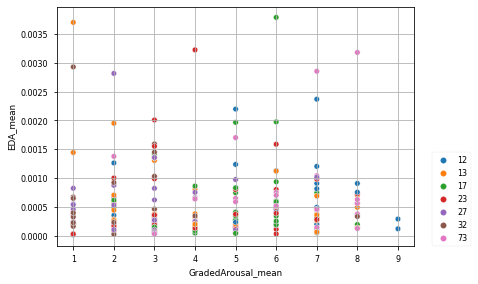

EDA vs graded arousal
Pearson correlation coefficient: 0.011431975879584251 - P_value: 0.867026730147977
Spearman correlation coefficient: 0.06895513416873723 - P_value: 0.311963880387607


In [34]:
print('EDA vs graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean', y='EDA_mean', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('EDA vs graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean'].values, df_uv['EDA_mean'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean'].values, df_uv['EDA_mean'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean EDA vs graded arousal

Centered mean EDA vs graded arousal


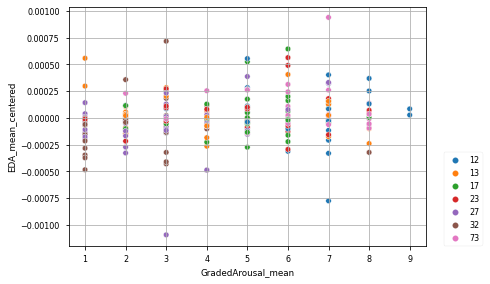

Centered mean EDA vs graded arousal
Pearson correlation coefficient: 0.19118727088609166 - P_value: 0.0047101604628909085
Spearman correlation coefficient: 0.21702048283704764 - P_value: 0.0012959610814364854


In [35]:
print('Centered mean EDA vs graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean', y='EDA_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered mean EDA vs graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean'].values, df_uv['EDA_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean'].values, df_uv['EDA_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean EDA vs centered graded arousal

Centered mean EDA vs centered graded arousal


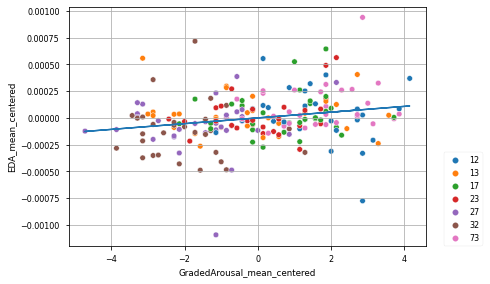

Centered mean EDA vs centered graded arousal
Pearson correlation coefficient: 0.2215262660197931 - P_value: 0.0010185482303470153
Spearman correlation coefficient: 0.25390636803439504 - P_value: 0.0001563134770121794


In [36]:
print('Centered mean EDA vs centered graded arousal')

x = df_uv['GradedArousal_mean_centered']
y = df_uv['EDA_mean_centered']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='EDA_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
#tikzplotlib.save("EdaGradedArousal.tex")
plt.show()

print('Centered mean EDA vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['EDA_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['EDA_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Mean absolute head pitch vs graded arousal

Mean absolute head pitch vs graded arousal


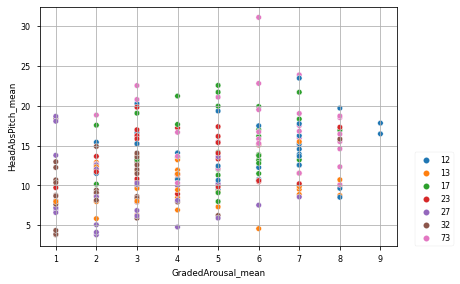

Mean absolute head pitch vs graded arousal
Pearson correlation coefficient: 0.352692697897754 - P_value: 9.397303193541416e-08
Spearman correlation coefficient: 0.36852852281872883 - P_value: 2.198568025323338e-08


In [37]:
print('Mean absolute head pitch vs graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean', y='HeadAbsPitch_mean', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Mean absolute head pitch vs graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean'].values, df_uv['HeadAbsPitch_mean'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean'].values, df_uv['HeadAbsPitch_mean'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean absolute head pitch vs centered graded arousal

Centered mean absolute head pitch vs centered graded arousal


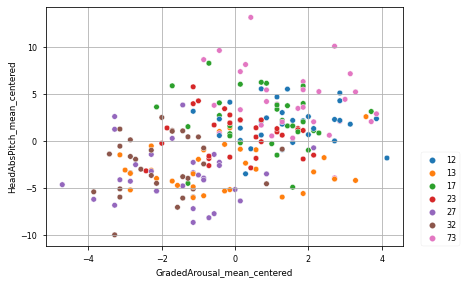

Centered mean absolute head pitch vs centered graded arousal
Pearson correlation coefficient: 0.41855370893597865 - P_value: 1.2962994640366438e-10
Spearman correlation coefficient: 0.4393098057958564 - P_value: 1.1850751859511416e-11


In [38]:
print('Centered mean absolute head pitch vs centered graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='HeadAbsPitch_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered mean absolute head pitch vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean absolute head pitch vs centered graded valence

Centered mean absolute head pitch vs centered graded valence


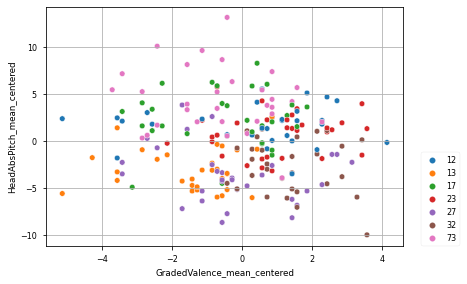

Centered mean absolute head pitch vs centered graded valence
Pearson correlation coefficient: -0.05498160439279552 - P_value: 0.42032271631166135
Spearman correlation coefficient: -0.016390103775280794 - P_value: 0.8102814627803465


In [39]:
print('Centered mean absolute head pitch vs centered graded valence')
sns.scatterplot(data=df_uv, x='GradedValence_mean_centered', y='HeadAbsPitch_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered mean absolute head pitch vs centered graded valence')
corr, p = pearsonr(df_uv['GradedValence_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedValence_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean absolute head pitch vs centered mean EDA

Centered mean absolute head pitch vs centered mean EDA


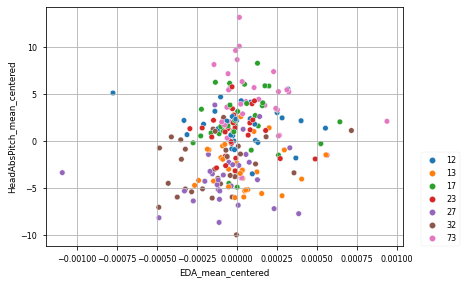

Centered mean absolute head pitch vs centered mean EDA
Pearson correlation coefficient: 0.17662379554394772 - P_value: 0.009125022714894447
Spearman correlation coefficient: 0.2255375169698934 - P_value: 0.0008186598403552557


In [40]:
print('Centered mean absolute head pitch vs centered mean EDA')
sns.scatterplot(data=df_uv, x='EDA_mean_centered', y='HeadAbsPitch_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered mean absolute head pitch vs centered mean EDA')
corr, p = pearsonr(df_uv['EDA_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['EDA_mean_centered'].values, df_uv['HeadAbsPitch_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered std head yaw vs centered graded arousal

Centered std head yaw vs centered graded arousal


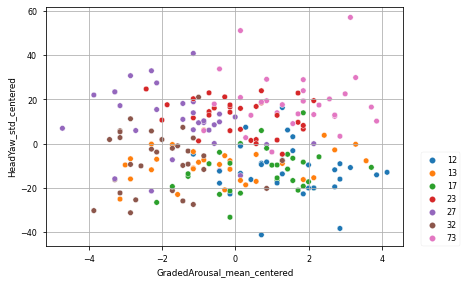

Centered std head yaw vs centered graded arousal
Pearson correlation coefficient: 0.016251215060083195 - P_value: 0.8118590725540706
Spearman correlation coefficient: 0.0035430625972676186 - P_value: 0.9586153183304063


In [41]:
print('Centered std head yaw vs centered graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='HeadYaw_std_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered std head yaw vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadYaw_std_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadYaw_std_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered std head yaw vs centered graded valence

Centered std head yaw vs centered graded valence


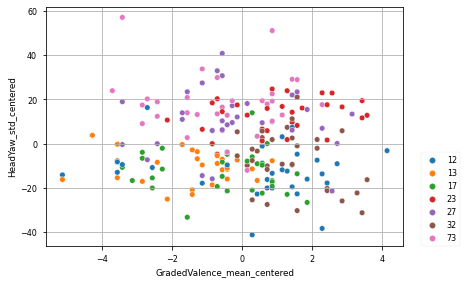

Centered std head yaw vs centered graded valence
Pearson correlation coefficient: -0.020609748585468657 - P_value: 0.762744213030526
Spearman correlation coefficient: -0.0070263447675058335 - P_value: 0.9180360036324875


In [42]:
print('Centered std head yaw vs centered graded valence')
sns.scatterplot(data=df_uv, x='GradedValence_mean_centered', y='HeadYaw_std_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered std head yaw vs centered graded valence')
corr, p = pearsonr(df_uv['GradedValence_mean_centered'].values, df_uv['HeadYaw_std_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedValence_mean_centered'].values, df_uv['HeadYaw_std_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered std gaze yaw vs centered graded arousal

Centered std gaze yaw vs centered graded arousal


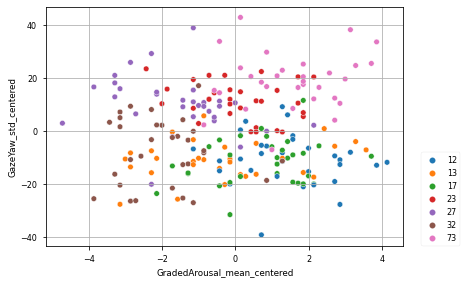

Centered std gaze yaw vs centered graded arousal
Pearson correlation coefficient: 0.03820438231050914 - P_value: 0.5756570524570027
Spearman correlation coefficient: 0.022562941569768076 - P_value: 0.7410257573118926


In [43]:
print('Centered std gaze yaw vs centered graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='GazeYaw_std_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered std gaze yaw vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeYaw_std_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeYaw_std_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean gaze absolute pitch vs centered graded arousal

Centered mean gaze absolute pitch vs centered graded arousal


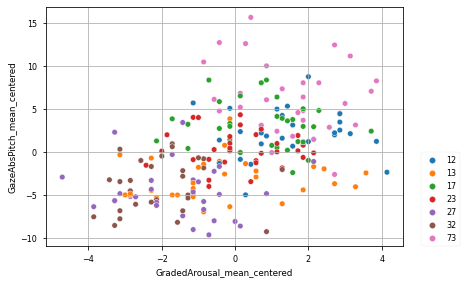

Centered mean gaze absolute pitch vs centered graded arousal
Pearson correlation coefficient: 0.47994745385945997 - P_value: 6.67000693506695e-14
Spearman correlation coefficient: 0.5159285344617687 - P_value: 3.69832516436516e-16


In [44]:
print('Centered mean gaze absolute pitch vs centered graded arousal')
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='GazeAbsPitch_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
plt.show()

print('Centered mean gaze absolute pitch vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeAbsPitch_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeAbsPitch_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean head speed vs centered graded arousal

Centered mean head speed vs centered graded arousal


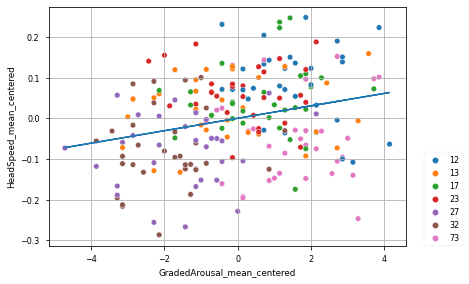

Centered mean head speed vs centered graded arousal
Pearson correlation coefficient: 0.2632947501054785 - P_value: 8.64907209734497e-05
Spearman correlation coefficient: 0.2481900077564427 - P_value: 0.0002217119967701497


In [45]:
print('Centered mean head speed vs centered graded arousal')

#linear model
x = df_uv['GradedArousal_mean_centered']
y = df_uv['HeadSpeed_mean_centered']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='HeadSpeed_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
#tikzplotlib.save("EdaGradedArousal.tex")
plt.show()

print('Centered mean head speed vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadSpeed_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['HeadSpeed_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

### Centered mean gaze speed vs centered graded arousal

Centered mean gaze speed vs centered graded arousal


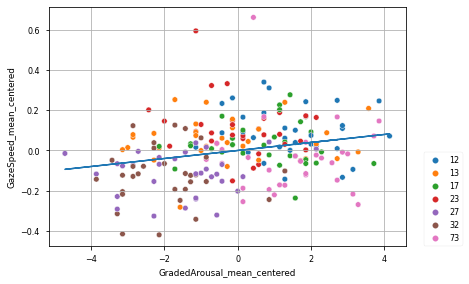

Centered mean gaze speed vs centered graded arousal
Pearson correlation coefficient: 0.23892056709661447 - P_value: 0.00038412867783012094
Spearman correlation coefficient: 0.243589077828658 - P_value: 0.0002920169716374422


In [46]:
print('Centered mean gaze speed vs centered graded arousal')

#linear model
x = df_uv['GradedArousal_mean_centered']
y = df_uv['GazeSpeed_mean_centered']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
sns.scatterplot(data=df_uv, x='GradedArousal_mean_centered', y='GazeSpeed_mean_centered', hue='VideoID')
plt.legend(loc=(1.05, 0.0))
#tikzplotlib.save("EdaGradedArousal.tex")
plt.show()

print('Centered mean gaze speed vs centered graded arousal')
corr, p = pearsonr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeSpeed_mean_centered'].values)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(df_uv['GradedArousal_mean_centered'].values, df_uv['GazeSpeed_mean_centered'].values)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## Content-motion-emotions correlations (saliency)

### Load saliency maps

In [47]:
h5f_gt_saliency = tables.open_file('./saliency_maps/gt_saliency.h5')

In [48]:
h5f_hl_saliency = {}
for video in model_data['VideoID'].unique():
    h5f_hl_saliency[video] = tables.open_file(f'./saliency_maps/high-level/video_{video}.h5')

In [49]:
h5f_ll_saliency = {}
for video in model_data['VideoID'].unique():
    h5f_ll_saliency[video] = tables.open_file(f'./saliency_maps/low-level/video_{video}.h5')

### Compute NSS between saliency maps

In [50]:
'''
These two functions were originally implemented by Erwan DAVID (IPI, LS2N, Nantes, France), 2018

E. DAVID, J. Guttiérez, A Coutrot, M. Perreira Da Silva, P. Le Callet (...). A Dataset of Head and Eye Movements for 360° Videos. ACM MMSys18, dataset and toolbox track
'''

def normalize(x, method='standard', axis=None):
    x = np.array(x, copy=False)
    if axis is not None:
        y = np.rollaxis(x, axis).reshape([x.shape[axis], -1])
        shape = np.ones(len(x.shape))
        shape[axis] = x.shape[axis]
        if method == 'standard':
            res = (x - np.mean(y, axis=1).reshape(shape)) / np.std(y, axis=1).reshape(shape)
        elif method == 'range':
            res = (x - np.min(y, axis=1).reshape(shape)) / (np.max(y, axis=1) - np.min(y, axis=1)).reshape(shape)
        elif method == 'sum':
            res = x / np.float_(np.sum(y, axis=1).reshape(shape))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    else:
        if method == 'standard':
            res = (x - np.mean(x)) / np.std(x)
        elif method == 'range':
            res = (x - np.min(x)) / (np.max(x) - np.min(x))
        elif method == 'sum':
            res = x / float(np.sum(x))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    return res

def NSS(saliency_map, fixation_map):
    s_map = np.array(saliency_map, copy=False)
    f_map = np.array(fixation_map, copy=False) > 0.5
    if s_map.shape != f_map.shape:
        s_map = resize(s_map, f_map.shape)
    # Normalize saliency map to have zero mean and unit std
    s_map = normalize(s_map, method='standard')
    # Mean saliency value at fixation locations
    return np.mean(s_map[f_map])

In [51]:
N = 150
users = model_data['UserID'].unique()
videos = model_data['VideoID'].unique()
NSS_150_records = []
for user in users:
    for video in videos:
        print(user, video)
        df = model_data[(model_data['UserID']==user)&(model_data['VideoID']==video)]
        if len(df) == 0:
            continue
        frames = df['Frame'].max()
        for i in tqdm(range(int(np.ceil(frames / N)))):
            df_frames = df[(i * N < df['Frame'])&(df['Frame'] <= (i + 1) * N)]
            eda = df_frames['EDA'].values.mean()
            hr = df_frames['HeartRate'].values.mean()
            hr_abs_grad = abs(np.gradient(df_frames['HeartRate'].values)).mean()
            idx = df_frames.index
            gt_sal = h5f_gt_saliency.root.carray[idx].astype(np.float64).mean(0)
            gt_sal /= gt_sal.max()
            hl_sal = h5f_hl_saliency[video].root.carray[i * N:(i + 1) * N].astype(np.float64).mean(0)
            ll_sal = h5f_ll_saliency[video].root.carray[i * N:(i + 1) * N].astype(np.float64).mean(0)
            hl_nss = NSS(hl_sal, gt_sal)
            ll_nss = NSS(ll_sal, gt_sal)
            NSS_150_records.append({'user': user, 'video': video, 'i': i, 'HL_NSS': hl_nss, 'LL_NSS': ll_nss,
                                    'EDA': eda, 'll_sum': ll_sal.sum(), 'hl_sum': hl_sal.sum(), 'HR': hr, 'HR_abs_grad': hr_abs_grad})

01 23


100%|███████████████████████████████████████████| 27/27 [01:07<00:00,  2.50s/it]


01 32


100%|███████████████████████████████████████████| 18/18 [00:45<00:00,  2.54s/it]


01 17


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.53s/it]


01 13


100%|███████████████████████████████████████████| 26/26 [01:02<00:00,  2.41s/it]


01 27


100%|███████████████████████████████████████████| 25/25 [01:02<00:00,  2.52s/it]


01 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.44s/it]


01 12


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.52s/it]


02 23
02 32
02 17


100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.57s/it]


02 13


100%|███████████████████████████████████████████| 26/26 [01:03<00:00,  2.43s/it]


02 27


100%|███████████████████████████████████████████| 25/25 [01:03<00:00,  2.53s/it]


02 73
02 12
03 23


100%|███████████████████████████████████████████| 27/27 [01:09<00:00,  2.59s/it]


03 32


100%|███████████████████████████████████████████| 18/18 [00:46<00:00,  2.58s/it]


03 17


100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.56s/it]


03 13


100%|███████████████████████████████████████████| 26/26 [01:03<00:00,  2.44s/it]


03 27


100%|███████████████████████████████████████████| 25/25 [01:03<00:00,  2.54s/it]


03 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.45s/it]


03 12


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.55s/it]


04 23


100%|███████████████████████████████████████████| 27/27 [01:10<00:00,  2.62s/it]


04 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


04 17


100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.60s/it]


04 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.47s/it]


04 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.58s/it]


04 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.47s/it]


04 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/it]


05 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.64s/it]


05 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.62s/it]


05 17


100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.60s/it]


05 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.50s/it]


05 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.58s/it]


05 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.49s/it]


05 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


06 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.63s/it]


06 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.65s/it]


06 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.62s/it]


06 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.49s/it]


06 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


06 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.48s/it]


06 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


07 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.63s/it]


07 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


07 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.63s/it]


07 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.49s/it]


07 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


07 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


07 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


08 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.65s/it]


08 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.65s/it]


08 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.62s/it]


08 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.48s/it]


08 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


08 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.50s/it]


08 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


10 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.64s/it]


10 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


10 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.63s/it]


10 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.50s/it]


10 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.60s/it]


10 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.49s/it]


10 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/it]


11 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.64s/it]


11 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


11 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.62s/it]


11 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.49s/it]


11 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


11 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


11 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/it]


12 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.65s/it]


12 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


12 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.62s/it]


12 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.50s/it]


12 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


12 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.49s/it]


12 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


13 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.63s/it]


13 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.62s/it]


13 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.62s/it]


13 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.49s/it]


13 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.58s/it]


13 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.47s/it]


13 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


14 23
14 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.63s/it]


14 17
14 13
14 27
14 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.47s/it]


14 12
15 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.63s/it]


15 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.64s/it]


15 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.64s/it]


15 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.51s/it]


15 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.60s/it]


15 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


15 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


16 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.65s/it]


16 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.66s/it]


16 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]


16 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


16 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.60s/it]


16 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


16 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]


17 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


17 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.66s/it]


17 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.65s/it]


17 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


17 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.59s/it]


17 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.50s/it]


17 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


18 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


18 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.67s/it]


18 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.63s/it]


18 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


18 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


18 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


18 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]


19 23


100%|███████████████████████████████████████████| 27/27 [01:12<00:00,  2.67s/it]


19 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.67s/it]


19 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]


19 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


19 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.62s/it]


19 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


19 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


20 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.67s/it]


20 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.67s/it]


20 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.64s/it]


20 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


20 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


20 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


20 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


21 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.67s/it]


21 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.67s/it]


21 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.67s/it]


21 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


21 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.60s/it]


21 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


21 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


22 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


22 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.66s/it]


22 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.64s/it]


22 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.51s/it]


22 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.60s/it]


22 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


22 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


23 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.67s/it]


23 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.66s/it]


23 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]


23 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


23 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.62s/it]


23 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.50s/it]


23 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.63s/it]


24 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


24 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.67s/it]


24 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.63s/it]


24 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


24 27


100%|███████████████████████████████████████████| 25/25 [01:04<00:00,  2.60s/it]


24 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.53s/it]


24 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]


25 23


100%|███████████████████████████████████████████| 27/27 [01:12<00:00,  2.67s/it]


25 32


100%|███████████████████████████████████████████| 18/18 [00:47<00:00,  2.66s/it]


25 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]


25 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


25 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


25 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


25 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


26 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


26 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.68s/it]


26 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.65s/it]


26 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


26 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


26 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.53s/it]


26 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/it]


27 23


100%|███████████████████████████████████████████| 27/27 [01:12<00:00,  2.67s/it]


27 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.67s/it]


27 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.65s/it]


27 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


27 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


27 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


27 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/it]


28 23


100%|███████████████████████████████████████████| 27/27 [01:12<00:00,  2.67s/it]


28 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.68s/it]


28 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]


28 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.52s/it]


28 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


28 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


28 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


29 23


100%|███████████████████████████████████████████| 27/27 [01:12<00:00,  2.67s/it]


29 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.69s/it]


29 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.64s/it]


29 13


100%|███████████████████████████████████████████| 26/26 [01:05<00:00,  2.51s/it]


29 27


100%|███████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


29 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


29 12


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


30 23


100%|███████████████████████████████████████████| 27/27 [01:11<00:00,  2.66s/it]


30 32


100%|███████████████████████████████████████████| 18/18 [00:48<00:00,  2.67s/it]


30 17


100%|███████████████████████████████████████████| 13/13 [00:34<00:00,  2.63s/it]


30 13


100%|███████████████████████████████████████████| 26/26 [01:04<00:00,  2.50s/it]


30 27


100%|███████████████████████████████████████████| 25/25 [01:03<00:00,  2.56s/it]


30 73


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.47s/it]


30 12


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]


31 23


100%|███████████████████████████████████████████| 27/27 [01:10<00:00,  2.61s/it]


31 32


100%|███████████████████████████████████████████| 18/18 [00:46<00:00,  2.60s/it]


31 17


100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.58s/it]


31 13


100%|███████████████████████████████████████████| 26/26 [01:03<00:00,  2.43s/it]


31 27


100%|███████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]


31 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.41s/it]


31 12


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.51s/it]


32 23


100%|███████████████████████████████████████████| 27/27 [01:09<00:00,  2.56s/it]


32 32


100%|███████████████████████████████████████████| 18/18 [00:46<00:00,  2.56s/it]


32 17


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.53s/it]


32 13


100%|███████████████████████████████████████████| 26/26 [01:02<00:00,  2.41s/it]


32 27


100%|███████████████████████████████████████████| 25/25 [01:02<00:00,  2.49s/it]


32 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.39s/it]


32 12


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


33 23


100%|███████████████████████████████████████████| 27/27 [01:08<00:00,  2.55s/it]


33 32


100%|███████████████████████████████████████████| 18/18 [00:45<00:00,  2.56s/it]


33 17


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.53s/it]


33 13


100%|███████████████████████████████████████████| 26/26 [01:02<00:00,  2.41s/it]


33 27


100%|███████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]


33 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.41s/it]


33 12


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.50s/it]


34 23


100%|███████████████████████████████████████████| 27/27 [01:08<00:00,  2.55s/it]


34 32


100%|███████████████████████████████████████████| 18/18 [00:45<00:00,  2.53s/it]


34 17


100%|███████████████████████████████████████████| 13/13 [00:32<00:00,  2.52s/it]


34 13


100%|███████████████████████████████████████████| 26/26 [01:02<00:00,  2.39s/it]


34 27


100%|███████████████████████████████████████████| 25/25 [01:01<00:00,  2.48s/it]


34 73


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.39s/it]


34 12


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


In [52]:
df_NSS_150 = pd.DataFrame.from_records(NSS_150_records)

In [53]:
df_NSS_150

user video   i    HL_NSS    LL_NSS       EDA        ll_sum        hl_sum  \
0      01    23   0  1.344119  2.732940  0.000205  2.968666e+06   2898.060000   
1      01    23   1 -0.213002  0.135526  0.000033  2.965243e+06   3040.540000   
2      01    23   2  0.109037  2.079924  0.000035  3.500661e+06   4074.626667   
3      01    23   3 -0.104953  1.420038  0.000127  3.597020e+06    752.546667   
4      01    23   4 -0.031903  0.812733  0.000038  3.421594e+06      4.846667   
...   ...   ...  ..       ...       ...       ...           ...           ...   
4492   34    12  15 -0.284270  0.100483  0.001454  2.347801e+06  14056.193333   
4493   34    12  16 -0.691086  0.058398  0.000805  2.285340e+06  20460.500000   
4494   34    12  17  0.505469  2.245569  0.000266  2.151101e+06  16557.993333   
4495   34    12  18  7.089677  3.349560  0.000103  2.933698e+06   1989.693333   
4496   34    12  19  8.373784  3.754498  0.000359  3.046450e+06   1141.755556   

              HR  HR_abs_grad  
0      72.467143     0.018304  
1      74.766728     0.013157  
2      69.658914     0.005844  
3      71.612981     0.005168  
4      72.422456     0.004808  
...          ...          ...  
4492  133.636490     0.175157  
4493   95.540896     0.066665  
4494   88.832381     0.009291  
4495   86.949106     0.018431  
4496   83.321804     0.017279  

[4497 rows x 10 columns]

In [54]:
df_NSS_150.to_pickle('./NSS_150.pkl')

## NSS

In [55]:
df_NSS_150 = pd.read_pickle('./NSS_150.pkl')

In [56]:
# Remove user 2 and user 14 because of incomplete data
idx = df_NSS_150[(df_NSS_150['user']=='02')|(df_NSS_150['user']=='14')].index
df_NSS_150 = df_NSS_150.drop(index=idx).reset_index(drop=True)

In [57]:
video_colors = {df_NSS_150['video'].unique()[i]:cm.get_cmap('tab10')(i / 10) for i in range(len(df_NSS_150['video'].unique()))}
user_colors = {df_NSS_150['user'].unique()[i]:cm.get_cmap('turbo')(i / len(df_NSS_150['user'].unique())) for i in range(len(df_NSS_150['user'].unique()))}

In [58]:
df_NSS_150['r_in'] = df_NSS_150['hl_sum'] / (216 * 384)
df_NSS_150['r_out'] = 1 - (df_NSS_150['hl_sum'] / (216 * 384))
df_NSS_150['NSS_diff'] = df_NSS_150['HL_NSS'] - df_NSS_150['LL_NSS']
df_NSS_150['HL_NSS_norm'] = df_NSS_150['HL_NSS'] / df_NSS_150['r_in']
df_NSS_150['LL_NSS_norm'] = df_NSS_150['LL_NSS'] / df_NSS_150['r_out']
df_NSS_150['NSS_diff_norm'] = df_NSS_150['HL_NSS'] / df_NSS_150['r_in'] - df_NSS_150['LL_NSS'] / df_NSS_150['r_out']

In [59]:
df_NSS_150

user video   i    HL_NSS    LL_NSS       EDA        ll_sum        hl_sum  \
0      01    23   0  1.344119  2.732940  0.000205  2.968666e+06   2898.060000   
1      01    23   1 -0.213002  0.135526  0.000033  2.965243e+06   3040.540000   
2      01    23   2  0.109037  2.079924  0.000035  3.500661e+06   4074.626667   
3      01    23   3 -0.104953  1.420038  0.000127  3.597020e+06    752.546667   
4      01    23   4 -0.031903  0.812733  0.000038  3.421594e+06      4.846667   
...   ...   ...  ..       ...       ...       ...           ...           ...   
4397   34    12  15 -0.284270  0.100483  0.001454  2.347801e+06  14056.193333   
4398   34    12  16 -0.691086  0.058398  0.000805  2.285340e+06  20460.500000   
4399   34    12  17  0.505469  2.245569  0.000266  2.151101e+06  16557.993333   
4400   34    12  18  7.089677  3.349560  0.000103  2.933698e+06   1989.693333   
4401   34    12  19  8.373784  3.754498  0.000359  3.046450e+06   1141.755556   

              HR  HR_abs_grad      r_in     r_out  NSS_diff  HL_NSS_norm  \
0      72.467143     0.018304  0.034940  0.965060 -1.388821    38.469402   
1      74.766728     0.013157  0.036658  0.963342 -0.348529    -5.810567   
2      69.658914     0.005844  0.049125  0.950875 -1.970887     2.219583   
3      71.612981     0.005168  0.009073  0.990927 -1.524991   -11.567686   
4      72.422456     0.004808  0.000058  0.999942 -0.844637  -545.977570   
...          ...          ...       ...       ...       ...          ...   
4397  133.636490     0.175157  0.169466  0.830534 -0.384753    -1.677447   
4398   95.540896     0.066665  0.246678  0.753322 -0.749485    -2.801566   
4399   88.832381     0.009291  0.199629  0.800371 -1.740100     2.532049   
4400   86.949106     0.018431  0.023988  0.976012  3.740117   295.546129   
4401   83.321804     0.017279  0.013765  0.986235  4.619286   608.322100   

      LL_NSS_norm  NSS_diff_norm  
0        2.831886      35.637516  
1        0.140683      -5.951251  
2        2.187379       0.032204  
3        1.433040     -13.000726  
4        0.812781    -546.790351  
...           ...            ...  
4397     0.120986      -1.798433  
4398     0.077521      -2.879088  
4399     2.805659      -0.273610  
4400     3.431885     292.114244  
4401     3.806902     604.515198  

[4402 rows x 16 columns]

In [60]:
sns.reset_orig()
plt.style.use('seaborn-paper')

In [61]:
mpl.rcParams.update({"axes.grid" : True})

## HL NSS vs EDA centered

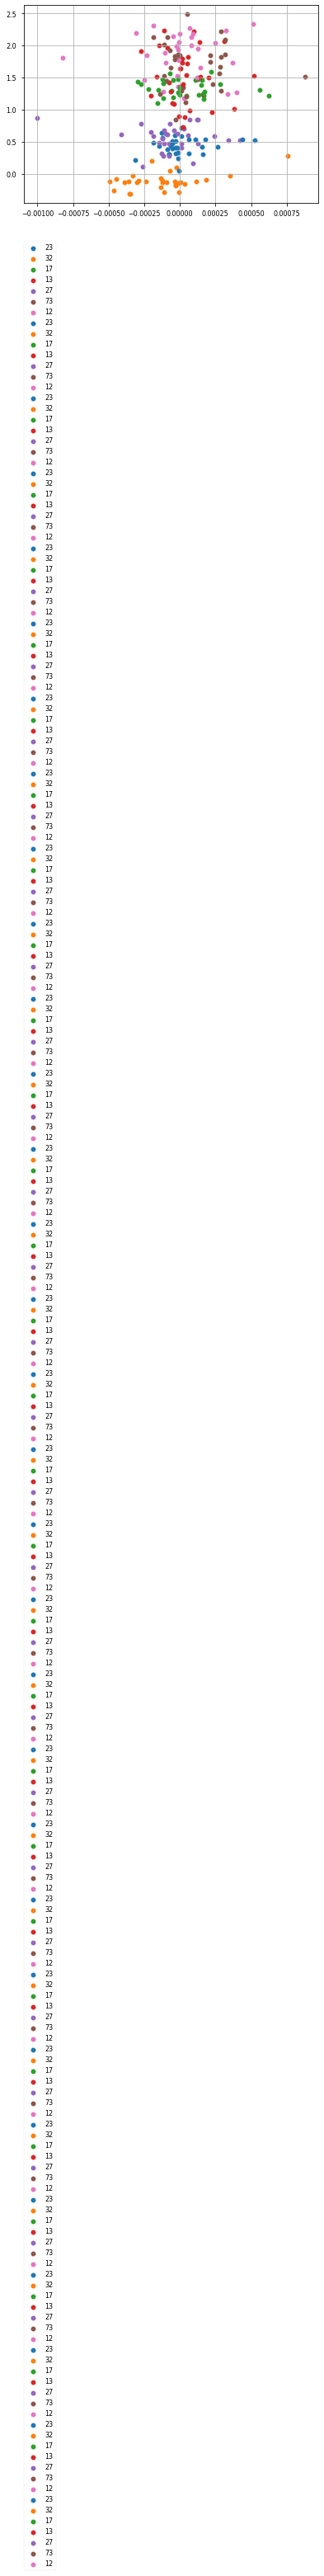

In [62]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [hl_nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

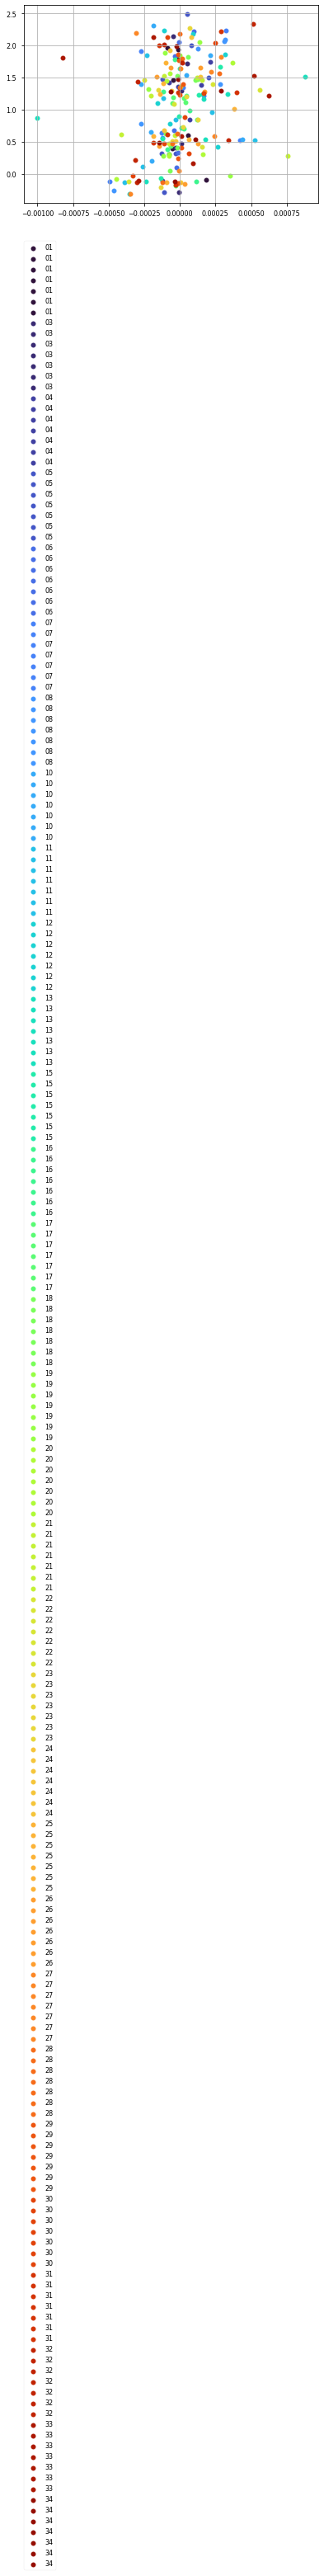

In [63]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [hl_nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [64]:
nss_data = []
eda_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        nss_data.append(hl_nss)
        eda_data.append(eda)
        
corr, p = pearsonr(eda_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(eda_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: 0.2317225106979861 - P_value: 0.0005801659598715029
Spearman correlation coefficient: 0.25760767955204183 - P_value: 0.00012411348204491722


## LL NSS vs EDA centered

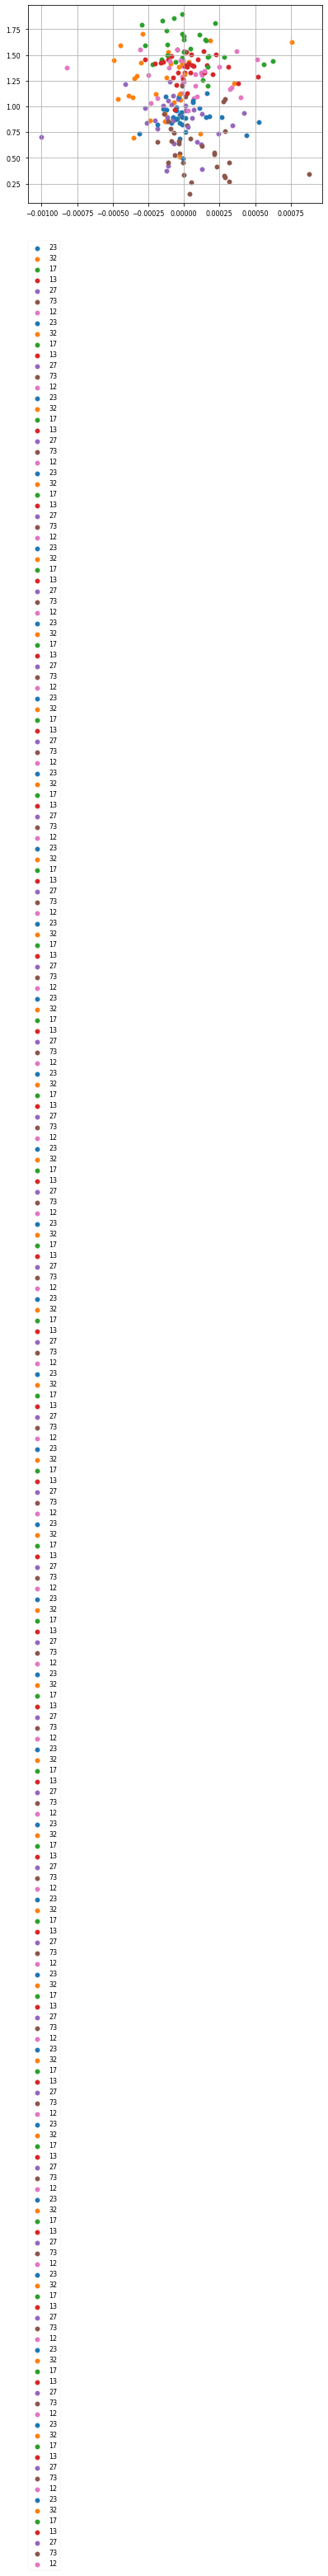

In [65]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [ll_nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

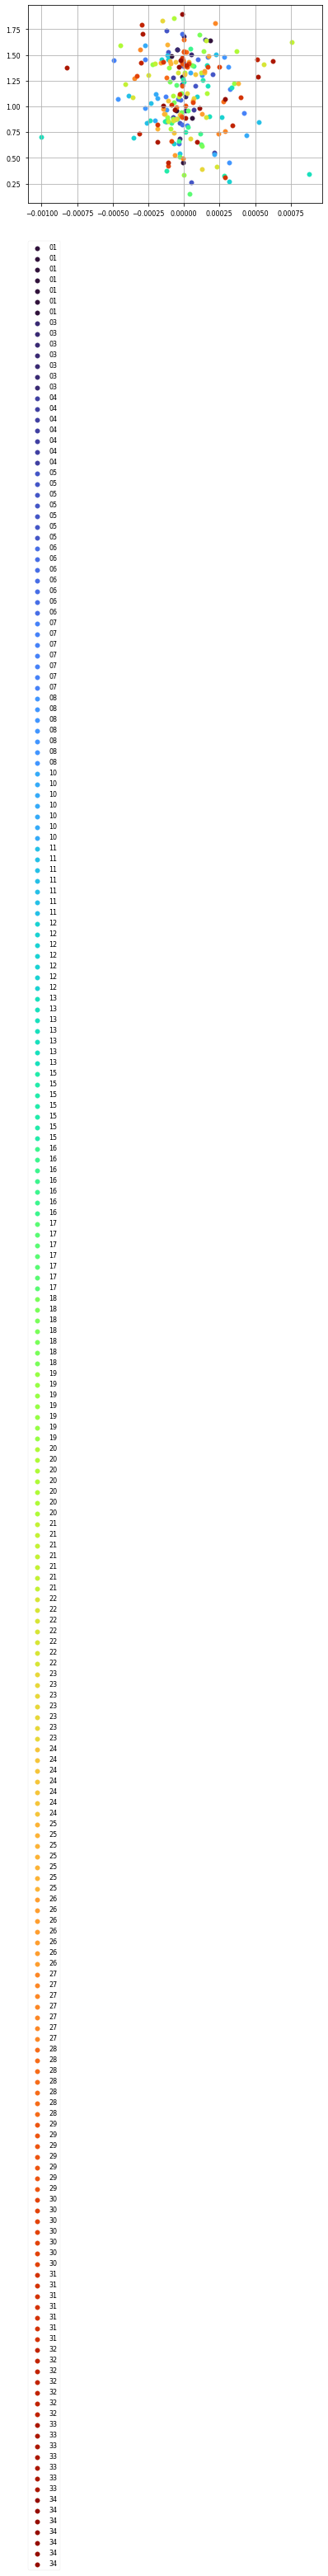

In [66]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [ll_nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [67]:
nss_data = []
eda_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        nss_data.append(ll_nss)
        eda_data.append(eda)
        
corr, p = pearsonr(eda_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(eda_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: -0.0607240100803888 - P_value: 0.3733714686269654
Spearman correlation coefficient: -0.018549444045152838 - P_value: 0.7858561286810013


## NSS diff vs EDA centered

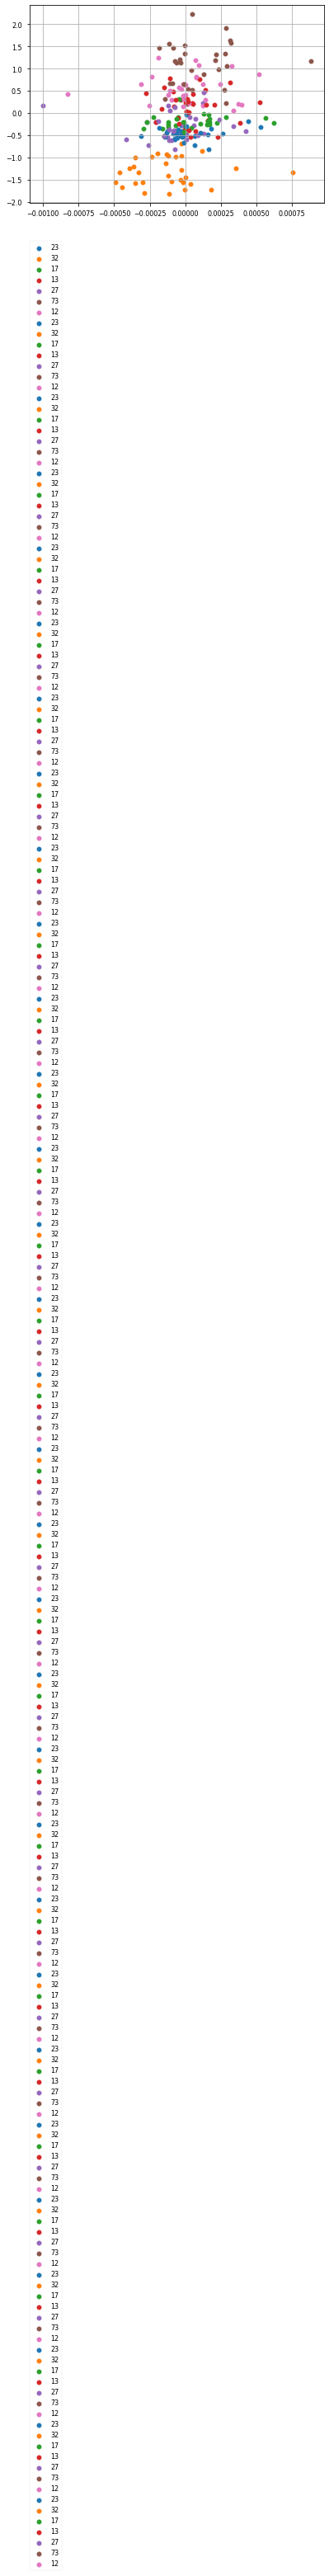

In [68]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [nss_diff], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

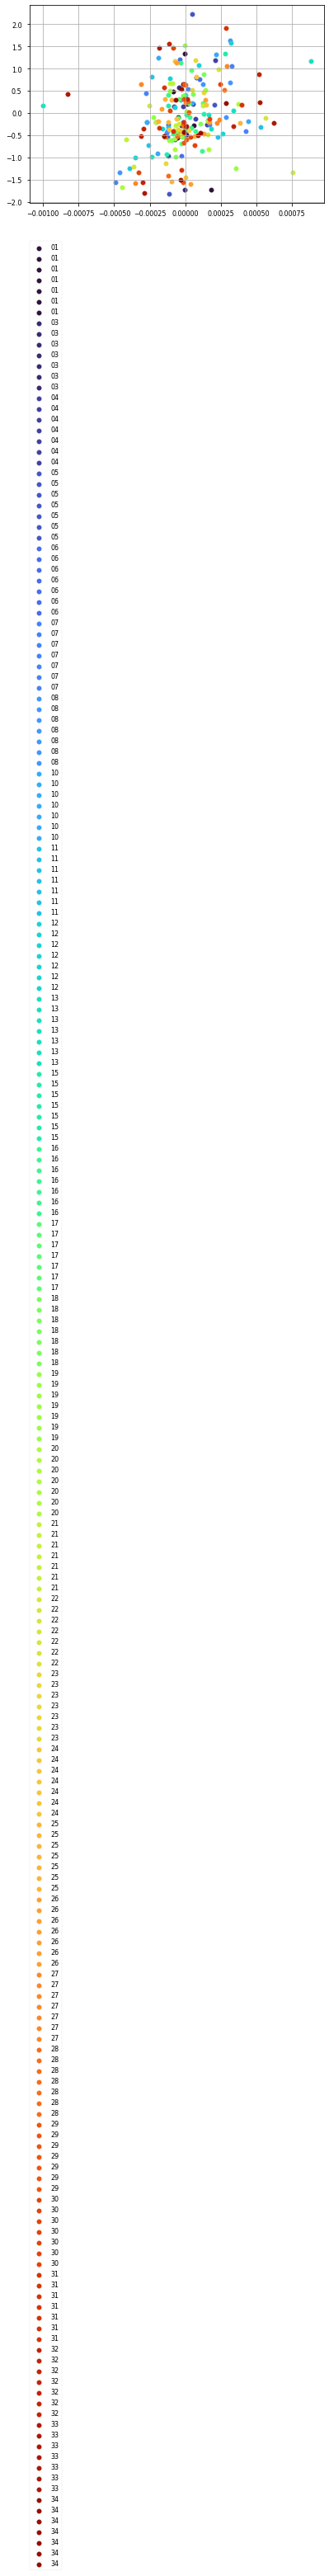

In [69]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [nss_diff], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [70]:
nss_data = []
eda_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        nss_data.append(nss_diff)
        eda_data.append(eda)
        
corr, p = pearsonr(eda_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(eda_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: 0.24800801346086543 - P_value: 0.0002241630139870973
Spearman correlation coefficient: 0.281127129750983 - P_value: 2.640922989274609e-05


## HL NSS vs graded arousal

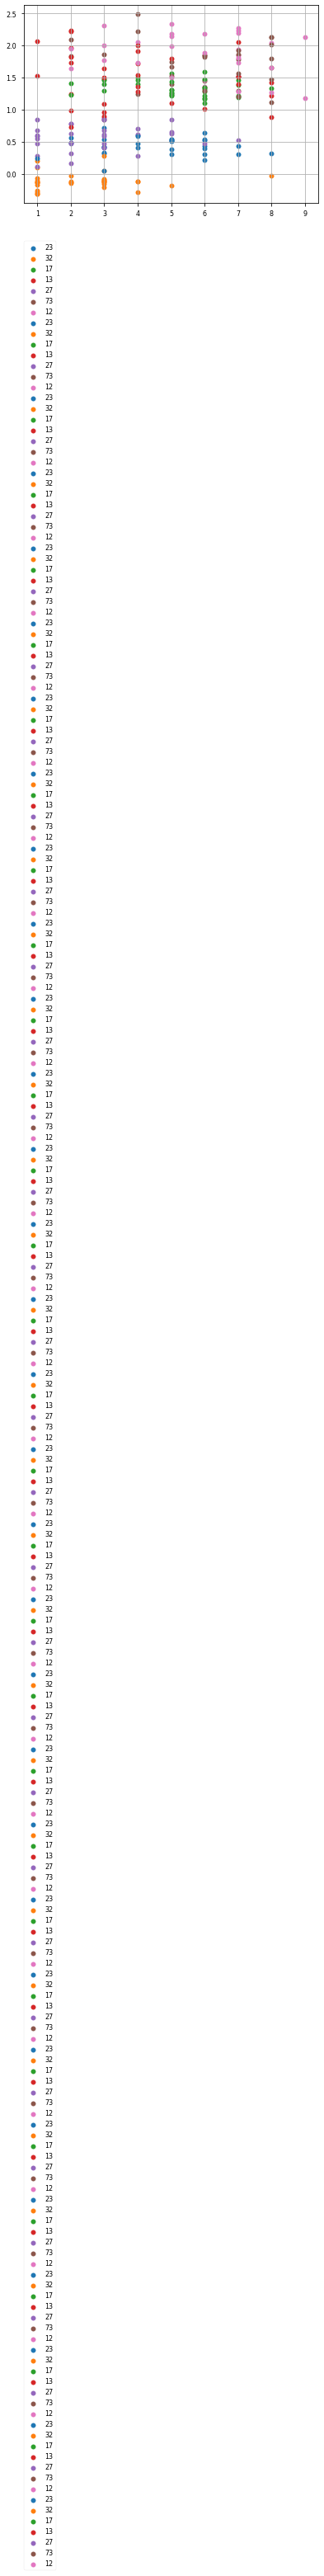

In [71]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [hl_nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

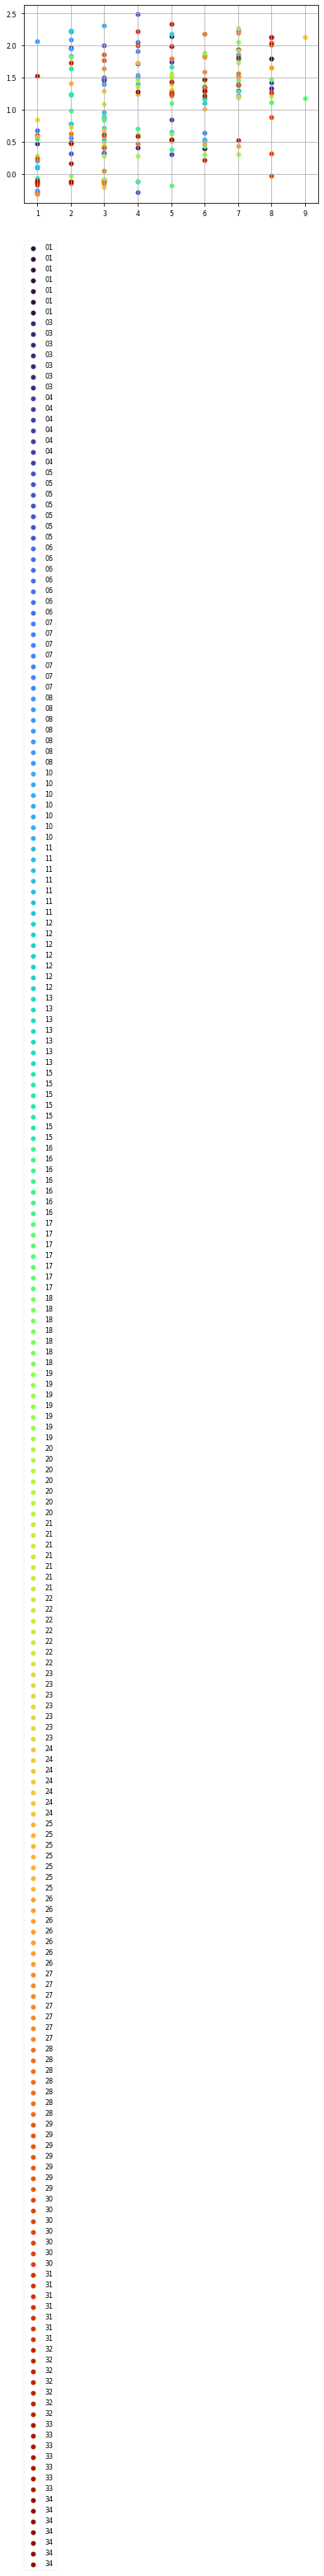

In [72]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [hl_nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [73]:
nss_data = []
aro_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(hl_nss)
        aro_data.append(arousal)
        
corr, p = pearsonr(aro_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(aro_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: 0.42811540869689657 - P_value: 4.393978381576361e-11
Spearman correlation coefficient: 0.40666413456226236 - P_value: 4.749937931990681e-10


## LL NSS vs graded arousal

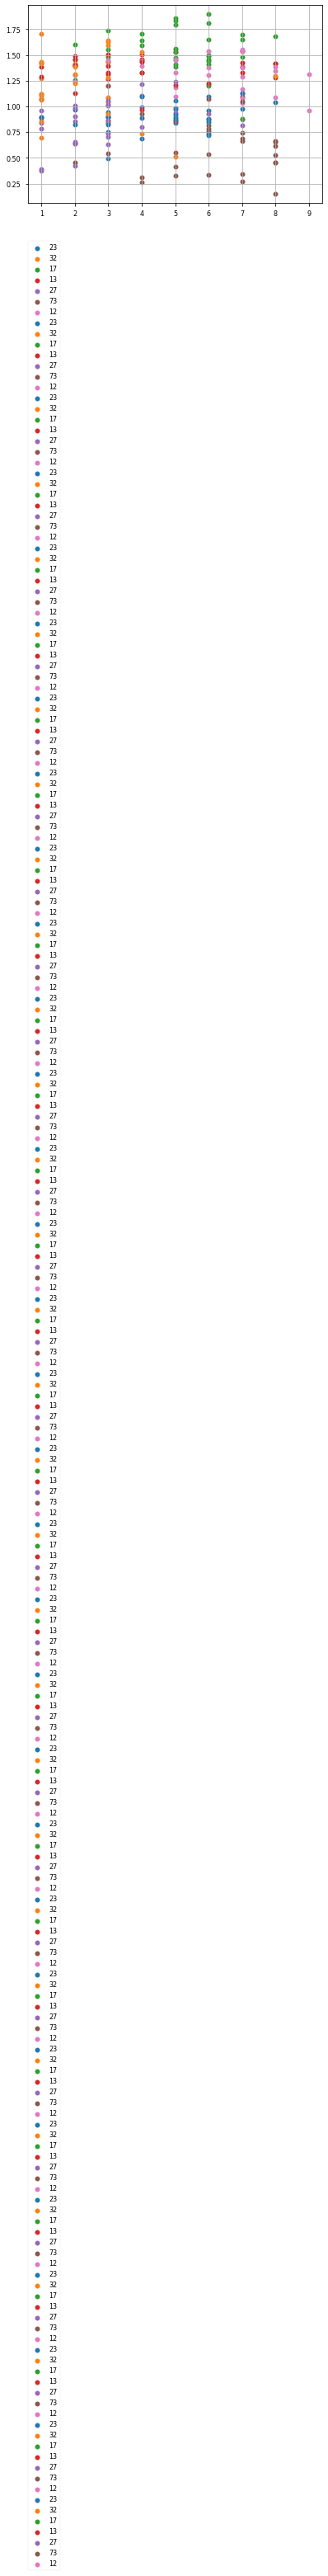

In [74]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [ll_nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

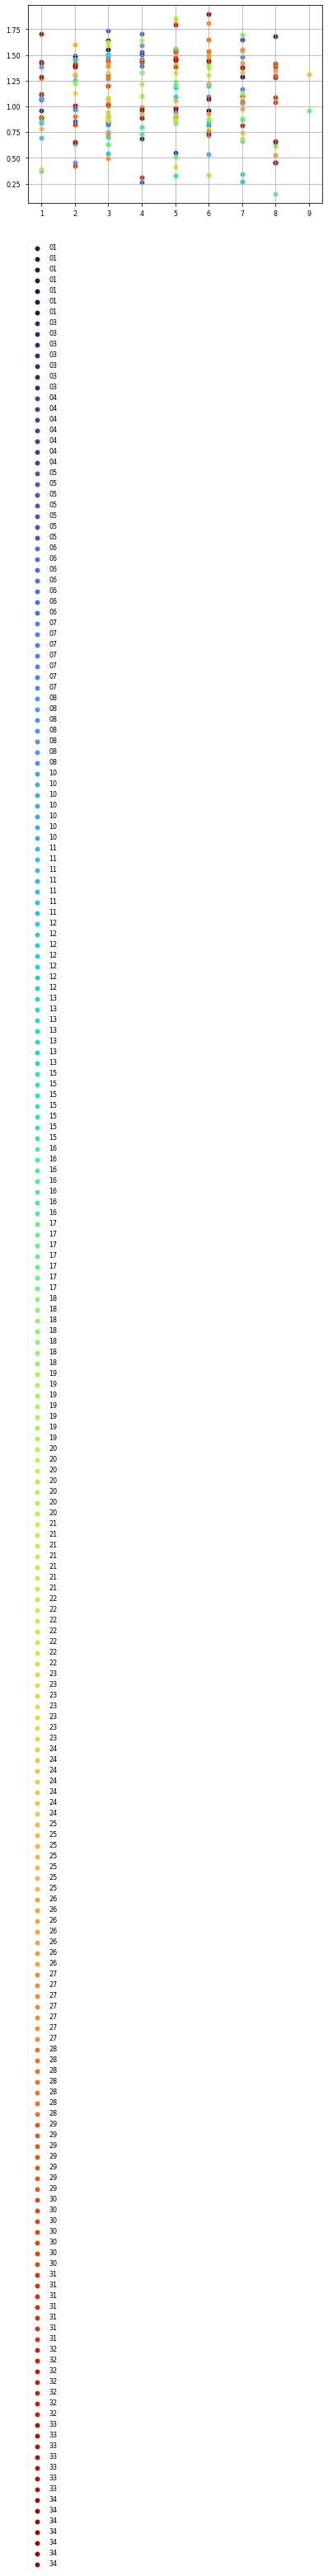

In [75]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [ll_nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [76]:
nss_data = []
aro_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        ll_nss = df_v['LL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(ll_nss)
        aro_data.append(arousal)
        
corr, p = pearsonr(aro_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(aro_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: -0.009119984227750086 - P_value: 0.893740556853019
Spearman correlation coefficient: 0.007500339361086453 - P_value: 0.912528095714541


## NSS diff vs graded arousal

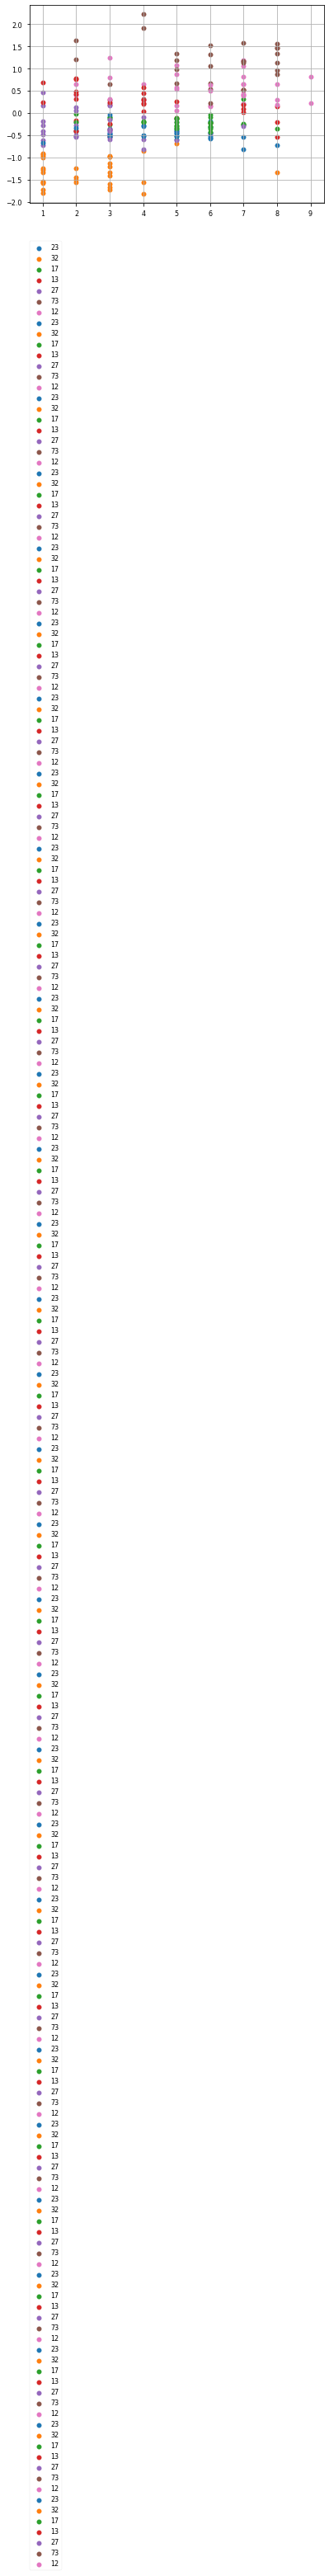

In [77]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [nss_diff], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

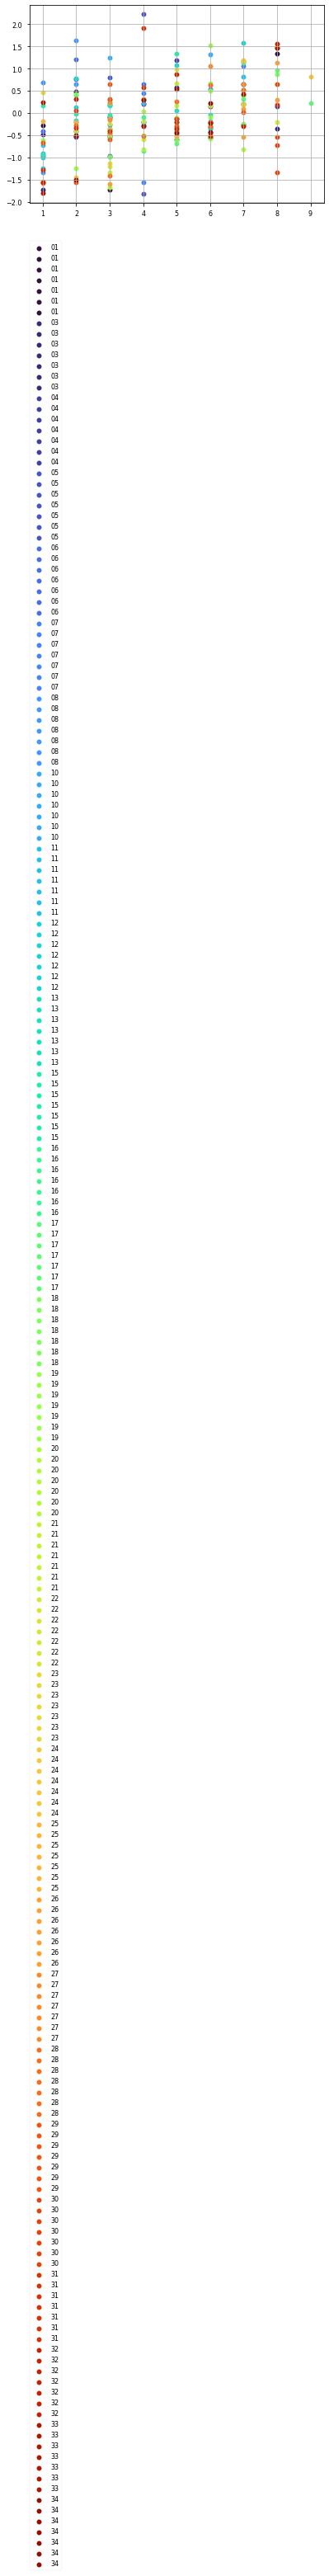

In [78]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [nss_diff], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [79]:
nss_data = []
aro_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(nss_diff)
        aro_data.append(arousal)
        
corr, p = pearsonr(aro_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(aro_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: 0.408888016445736 - P_value: 3.7400234181540826e-10
Spearman correlation coefficient: 0.3897249795060077 - P_value: 2.7718642800539512e-09


## HL NSS / R_IN - LL NSS / R_OUT vs EDA centered

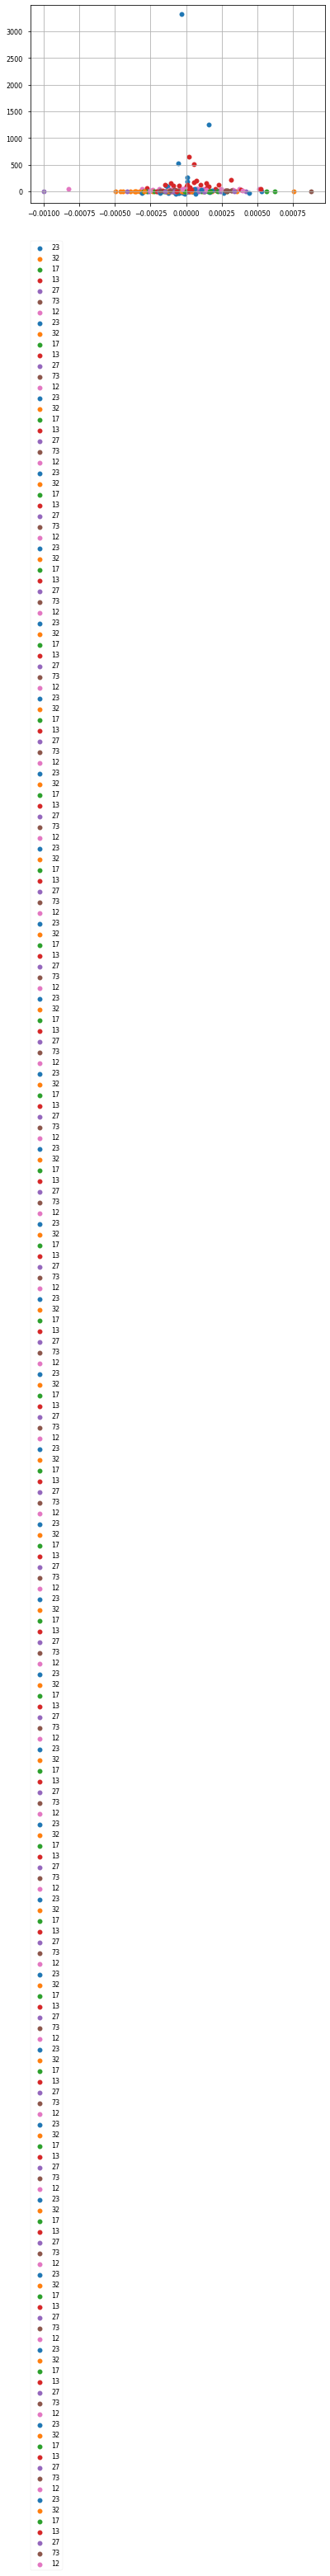

In [80]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss = df_v['NSS_diff_norm'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

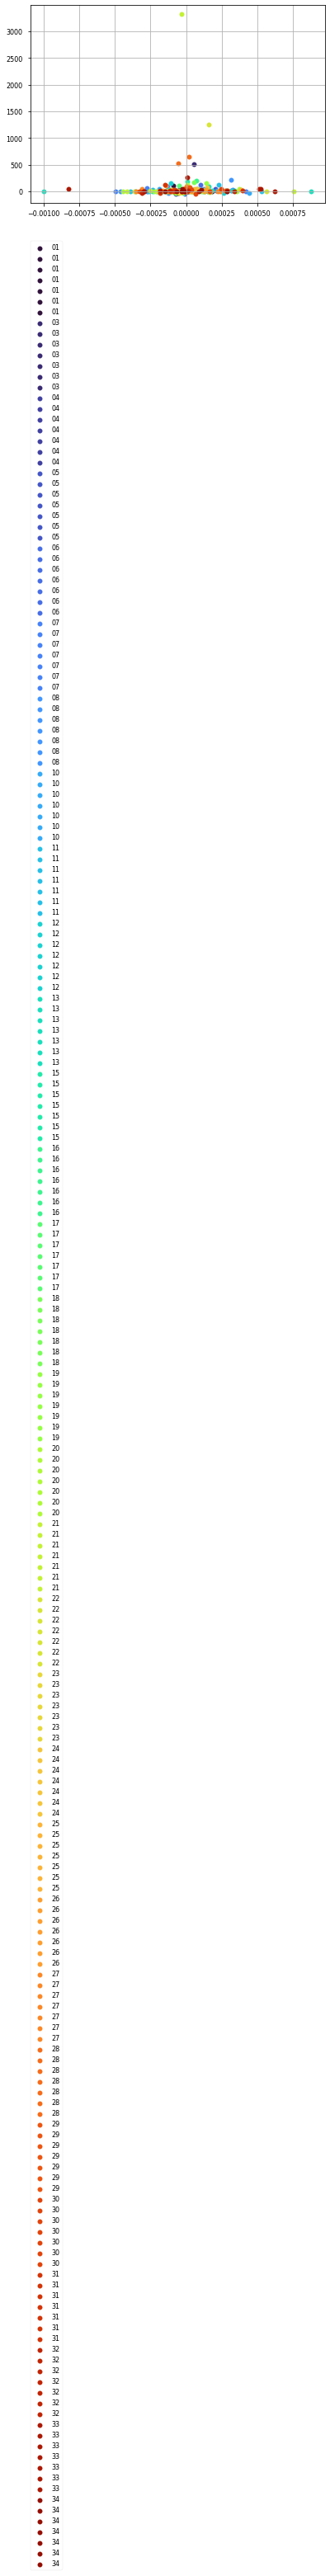

In [81]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss = df_v['NSS_diff_norm'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        plt.scatter([eda], [nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [82]:
nss_data = []
eda_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff_norm'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        nss_data.append(nss_diff)
        eda_data.append(eda)
        
corr, p = pearsonr(eda_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(eda_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: 0.022517180319514572 - P_value: 0.7415323366694936
Spearman correlation coefficient: 0.27852703673952567 - P_value: 3.155857738861644e-05


## HL NSS / R_IN AND LL NSS / R_OUT vs EDA centered

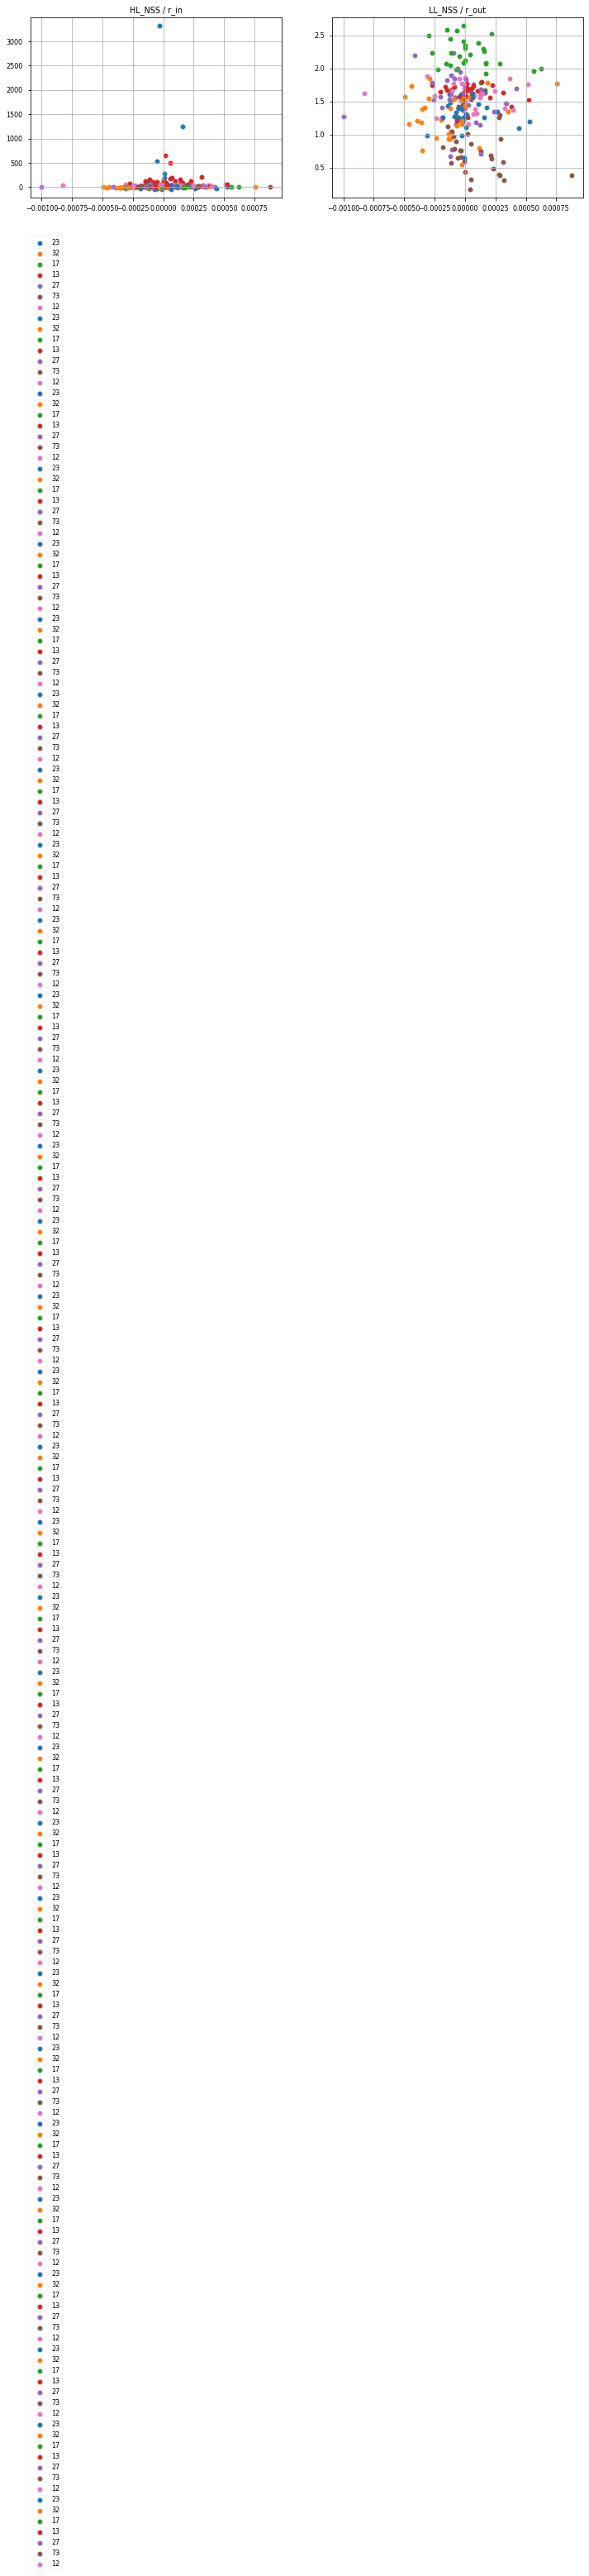

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS_norm'].mean()
        ll_nss = df_v['LL_NSS_norm'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        ax1.scatter([eda], [hl_nss], c=[video_colors[video]], label=video)
        ax2.scatter([eda], [ll_nss], c=[video_colors[video]])
ax1.set_title('HL_NSS / r_in')
ax2.set_title('LL_NSS / r_out')
ax1.legend(loc=(0.0, -13.2))
plt.show()

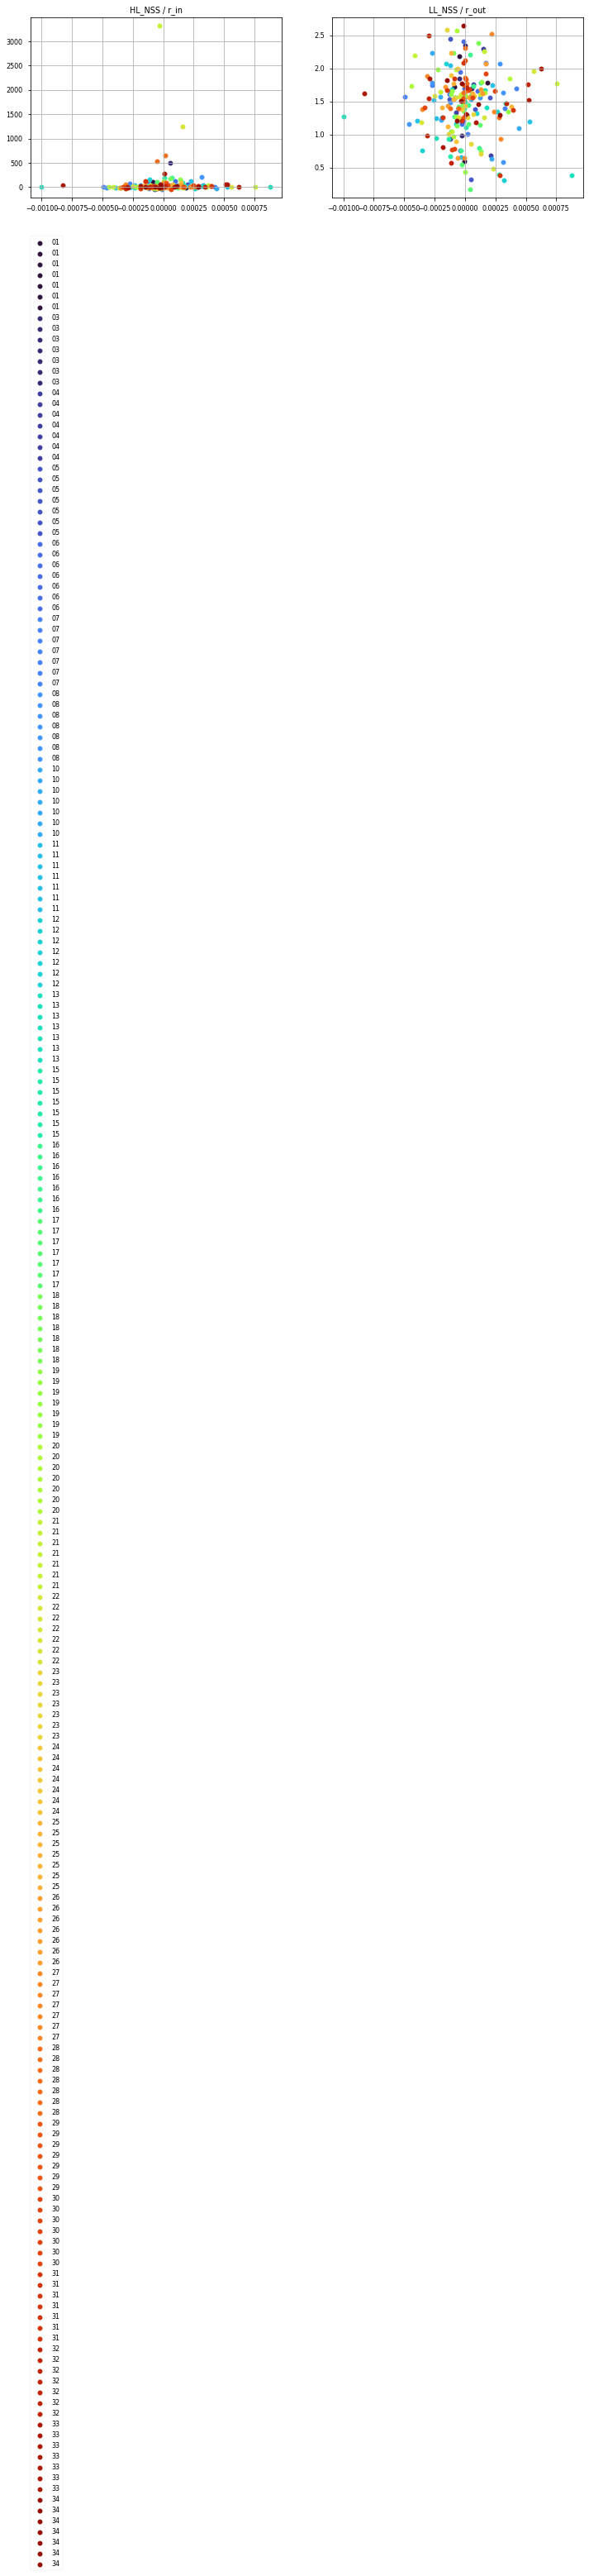

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS_norm'].mean()
        ll_nss = df_v['LL_NSS_norm'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        ax1.scatter([eda], [hl_nss], c=[user_colors[user]], label=user)
        ax2.scatter([eda], [ll_nss], c=[user_colors[user]])
ax1.set_title('HL_NSS / r_in')
ax2.set_title('LL_NSS / r_out')
ax1.legend(loc=(0.0, -13.2))
plt.show()

## HL NSS / R_IN - LL NSS / R_OUT vs graded arousal

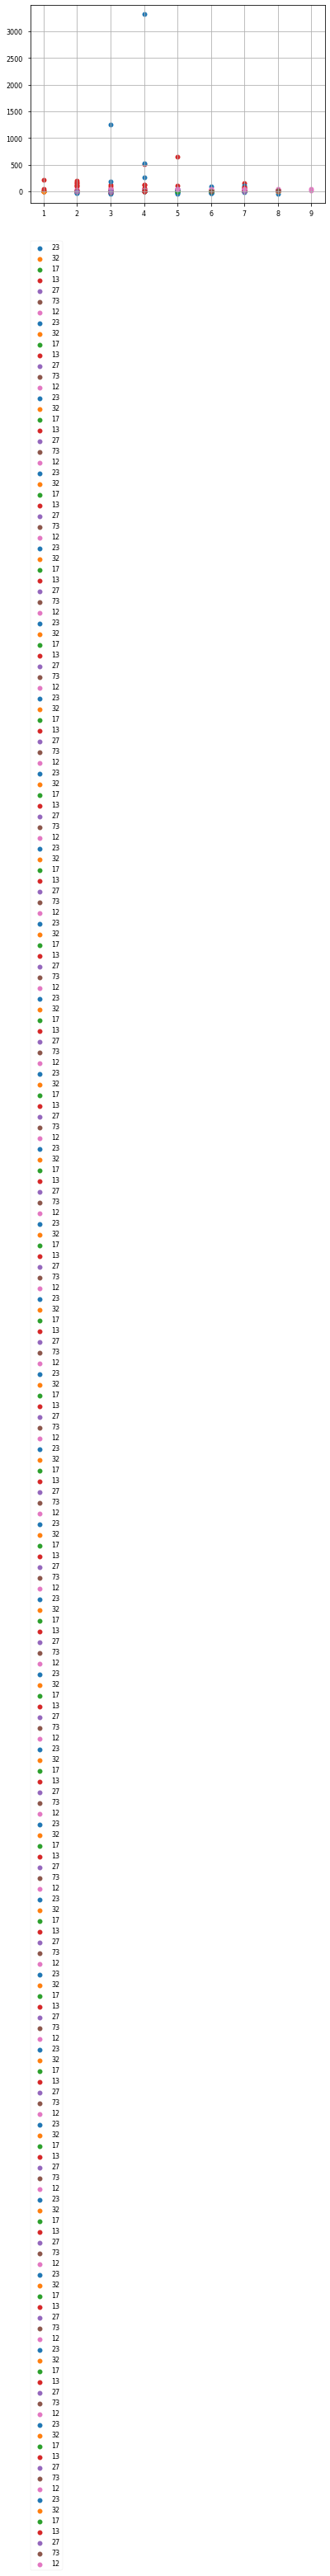

In [85]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss = df_v['NSS_diff_norm'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [nss], c=[video_colors[video]], label=video)
plt.legend(loc=(0.0, -12))
plt.show()

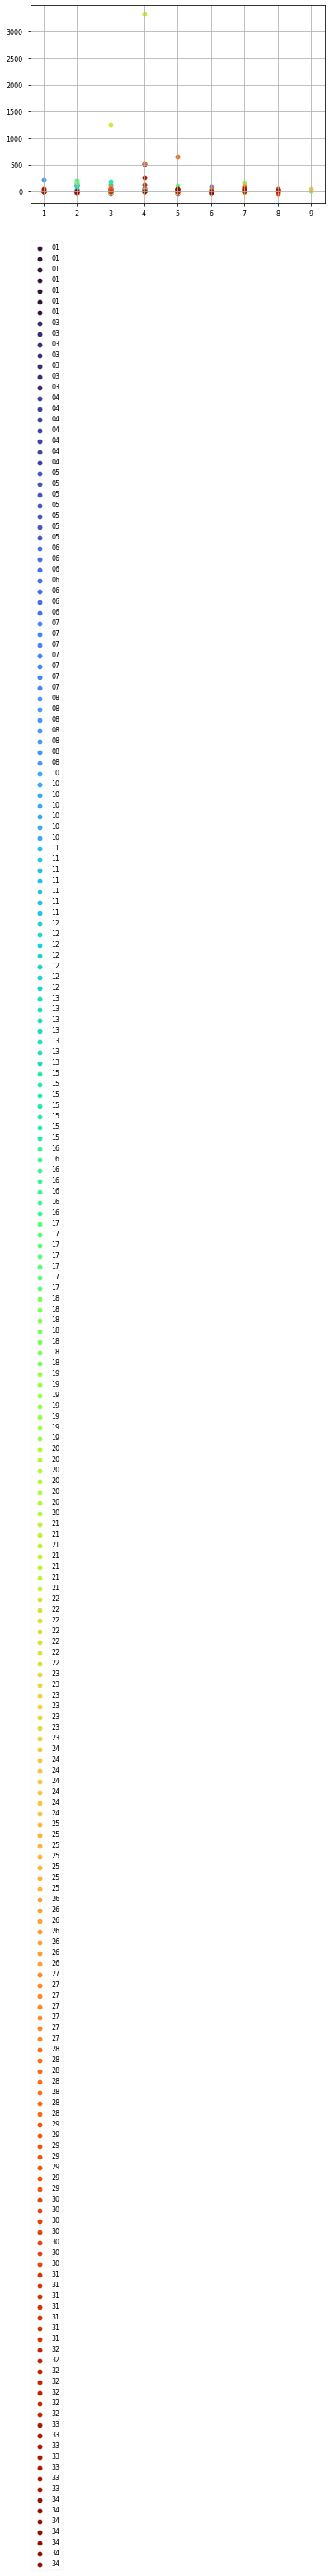

In [86]:
for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss = df_v['NSS_diff_norm'].mean()
        _, arousal = get_valence_arousal(user, video)
        plt.scatter([arousal], [nss], c=[user_colors[user]], label=user)
plt.legend(loc=(0.0, -12))
plt.show()

In [87]:
nss_data = []
aro_data = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff_norm'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(nss_diff)
        aro_data.append(arousal)
        
corr, p = pearsonr(aro_data, nss_data)
print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
corr, p = spearmanr(aro_data, nss_data)
print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

Pearson correlation coefficient: -0.023487751009051636 - P_value: 0.7308122320950875
Spearman correlation coefficient: 0.275256530113199 - P_value: 3.938509420691362e-05


## HL NSS / R_IN AND LL NSS / R_OUT vs graded arousal

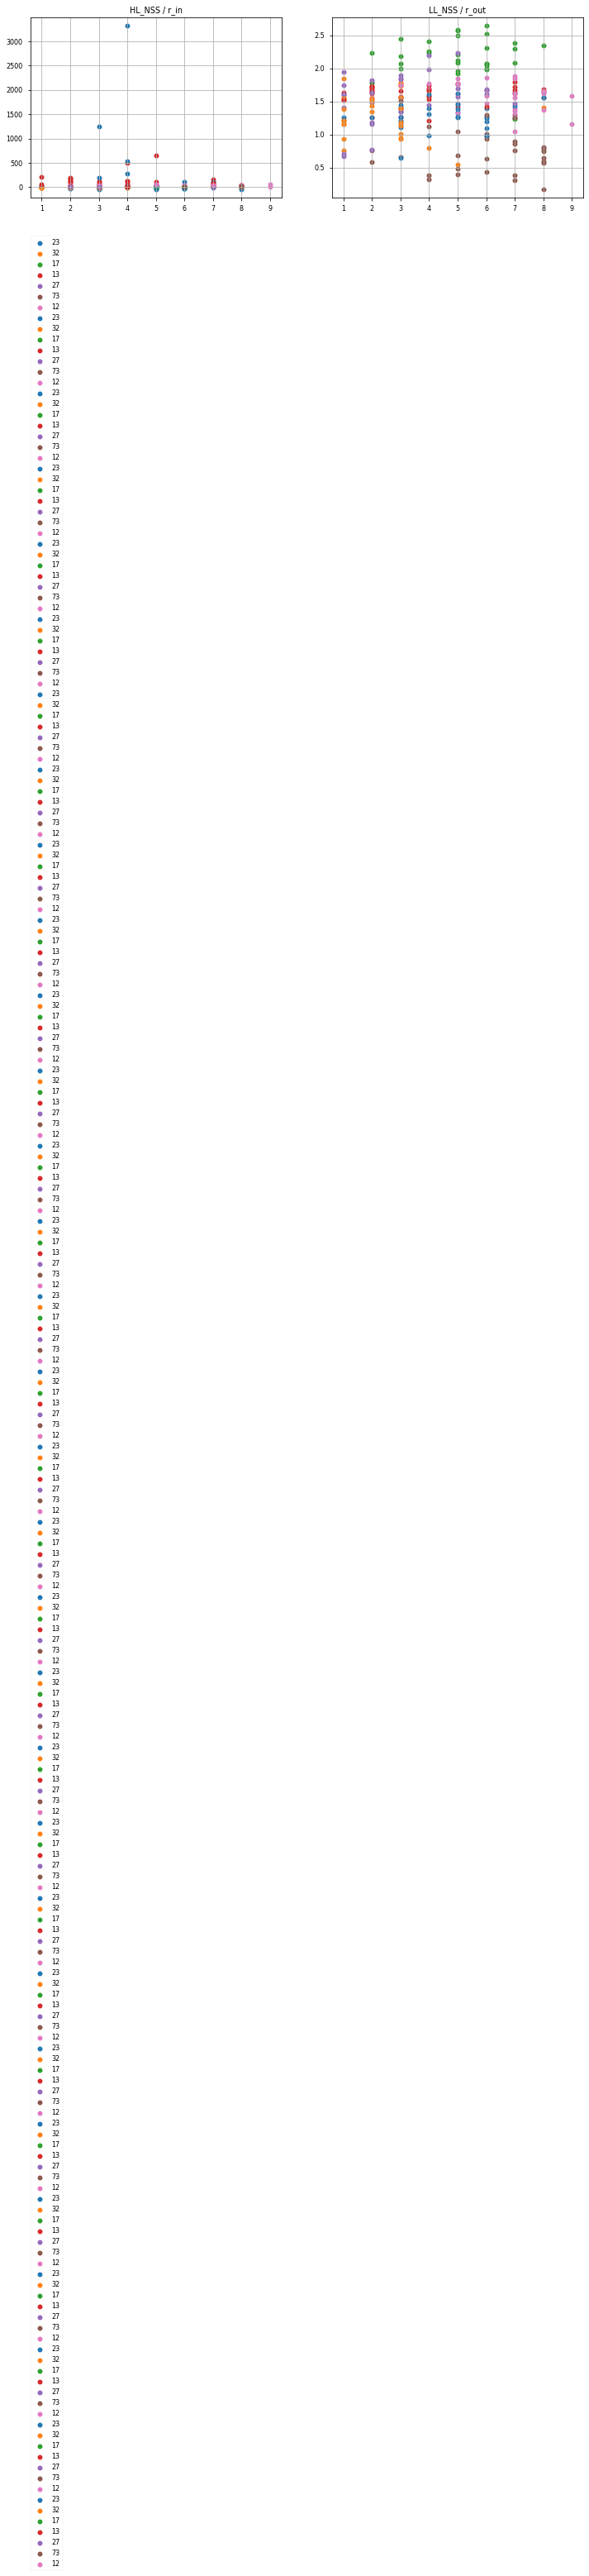

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS_norm'].mean()
        ll_nss = df_v['LL_NSS_norm'].mean()
        _, arousal = get_valence_arousal(user, video)
        ax1.scatter([arousal], [hl_nss], c=[video_colors[video]], label=video)
        ax2.scatter([arousal], [ll_nss], c=[video_colors[video]])
ax1.set_title('HL_NSS / r_in')
ax2.set_title('LL_NSS / r_out')
ax1.legend(loc=(0.0, -13.2))
plt.show()

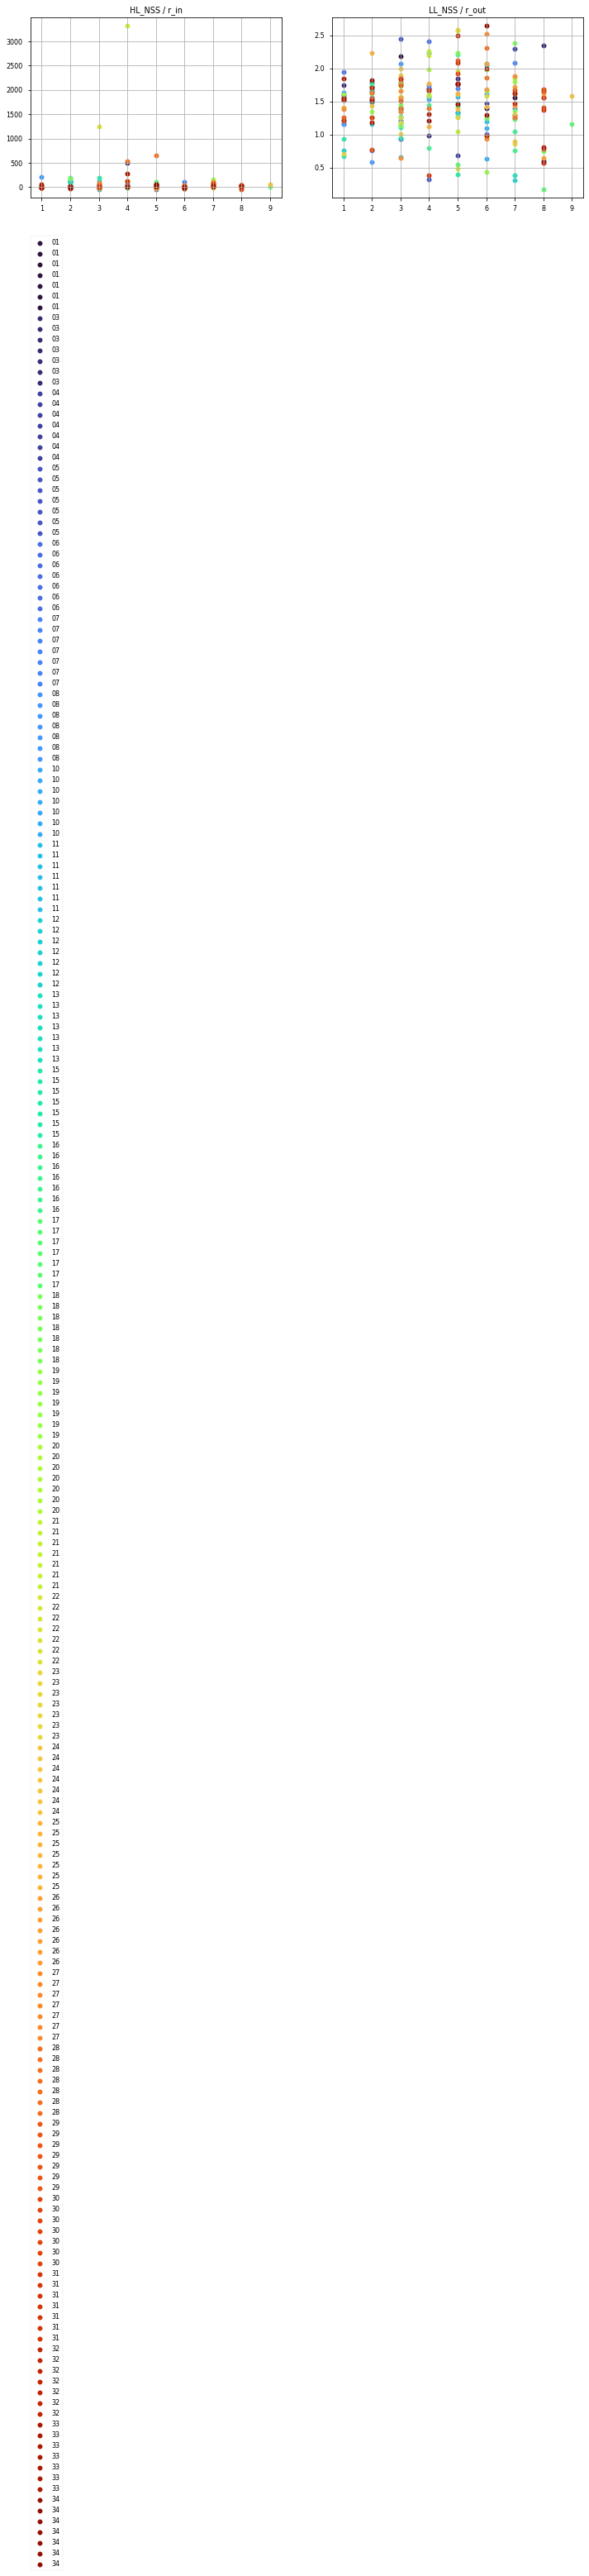

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        hl_nss = df_v['HL_NSS_norm'].mean()
        ll_nss = df_v['LL_NSS_norm'].mean()
        _, arousal = get_valence_arousal(user, video)
        ax1.scatter([arousal], [hl_nss], c=[user_colors[user]], label=user)
        ax2.scatter([arousal], [ll_nss], c=[user_colors[user]])
ax1.set_title('HL_NSS / r_in')
ax2.set_title('LL_NSS / r_out')
ax1.legend(loc=(0.0, -13.2))
plt.show()

## HL NSS vs EDA centered separated videos

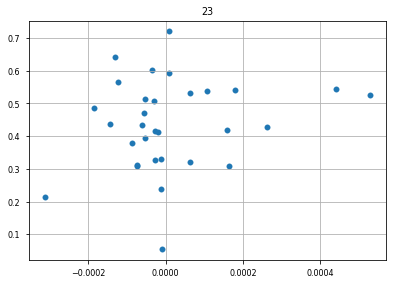

Pearson correlation coefficient: 0.20248489364976766 - P_value: 0.2746467754132035
Spearman correlation coefficient: 0.1342741935483871 - P_value: 0.47142898795379495


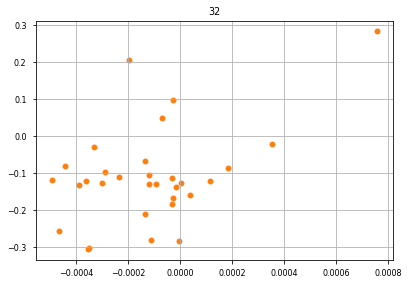

Pearson correlation coefficient: 0.4703447488354012 - P_value: 0.00758212062759571
Spearman correlation coefficient: 0.1649193548387097 - P_value: 0.37529921962674617


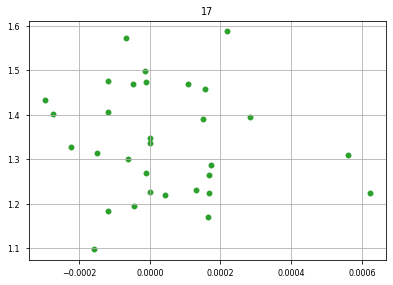

Pearson correlation coefficient: -0.11698986179361431 - P_value: 0.5308149576588573
Spearman correlation coefficient: -0.14798387096774193 - P_value: 0.42692251600323894


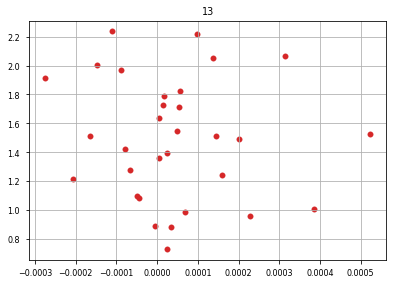

Pearson correlation coefficient: -0.11025398571723473 - P_value: 0.5548913470684651
Spearman correlation coefficient: -0.08266129032258066 - P_value: 0.6584288842644177


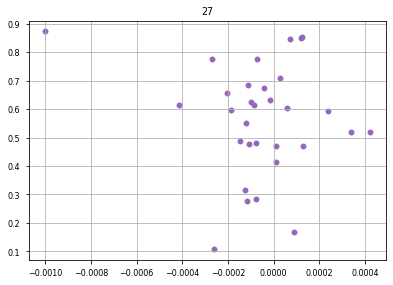

Pearson correlation coefficient: -0.13911739796921446 - P_value: 0.4554359103781624
Spearman correlation coefficient: -0.017741935483870968 - P_value: 0.9245286715887115


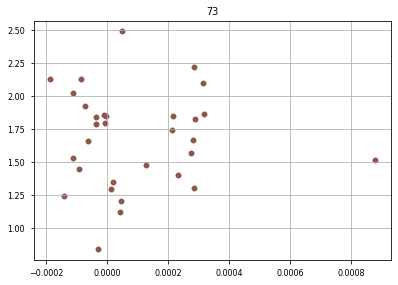

Pearson correlation coefficient: -0.008349887093554897 - P_value: 0.9644417610608885
Spearman correlation coefficient: -0.015322580645161293 - P_value: 0.9347967683001777


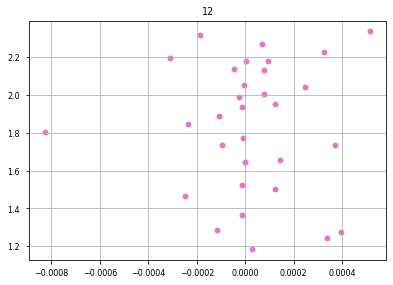

Pearson correlation coefficient: -0.00674782849936287 - P_value: 0.9712610472089096
Spearman correlation coefficient: 0.017741935483870968 - P_value: 0.9245286715887115


In [90]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    eda_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        average_user_eda = df_u['EDA'].mean()
        df_uv = df_u[df_u['video']==video]
        hl_nss = df_uv['HL_NSS'].mean()
        eda = df_uv['EDA'].mean() - average_user_eda
        nss_data.append(hl_nss)
        eda_data.append(eda)
        plt.scatter([eda], [hl_nss], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(eda_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(eda_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## LL NSS vs EDA centered separated videos

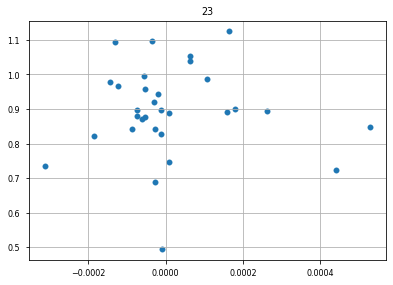

Pearson correlation coefficient: -0.024938662696088226 - P_value: 0.894061282366343
Spearman correlation coefficient: 0.00403225806451613 - P_value: 0.982824379813206


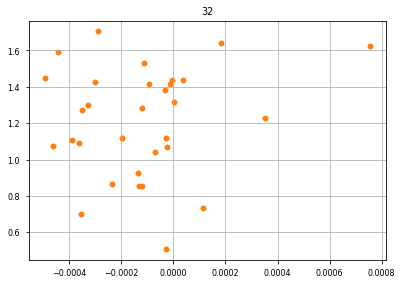

Pearson correlation coefficient: 0.14016257381407332 - P_value: 0.45202294738560805
Spearman correlation coefficient: 0.11814516129032258 - P_value: 0.5267365934227508


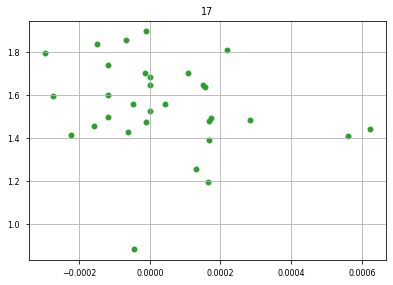

Pearson correlation coefficient: -0.23155654828957017 - P_value: 0.21006370618750095
Spearman correlation coefficient: -0.2774193548387097 - P_value: 0.1307968407330003


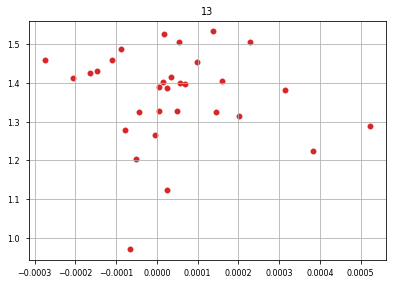

Pearson correlation coefficient: -0.09811948964402478 - P_value: 0.5994954744223498
Spearman correlation coefficient: -0.10725806451612906 - P_value: 0.5657596880755809


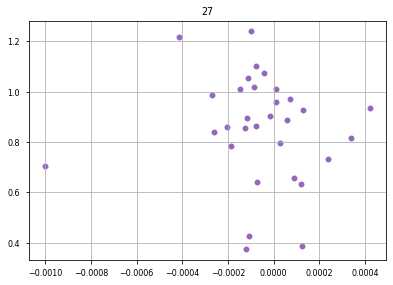

Pearson correlation coefficient: -0.07253615207944553 - P_value: 0.698179430090912
Spearman correlation coefficient: -0.15080645161290326 - P_value: 0.4180570225304582


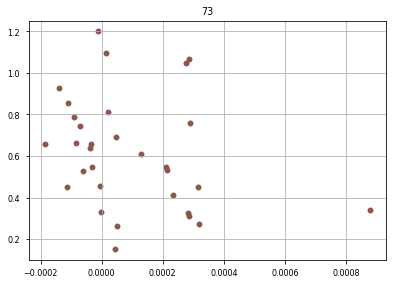

Pearson correlation coefficient: -0.27595208350188905 - P_value: 0.13292967240387482
Spearman correlation coefficient: -0.3467741935483872 - P_value: 0.05597941859776836


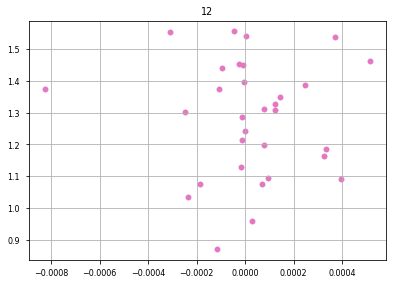

Pearson correlation coefficient: -0.01672628578267069 - P_value: 0.9288378817997452
Spearman correlation coefficient: -0.013709677419354839 - P_value: 0.9416479796430431


In [91]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    eda_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        average_user_eda = df_u['EDA'].mean()
        df_uv = df_u[df_u['video']==video]
        ll_nss = df_uv['LL_NSS'].mean()
        eda = df_uv['EDA'].mean() - average_user_eda
        nss_data.append(ll_nss)
        eda_data.append(eda)
        plt.scatter([eda], [ll_nss], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(eda_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(eda_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## NSS diff vs EDA centered separated videos

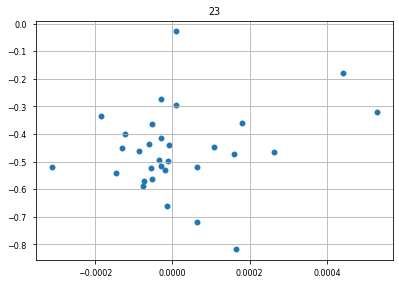

Pearson correlation coefficient: 0.2075317240600922 - P_value: 0.26260539234871194
Spearman correlation coefficient: 0.1745967741935484 - P_value: 0.3475210954433021


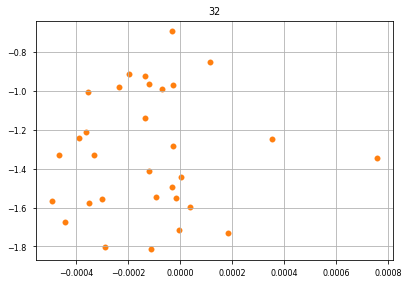

Pearson correlation coefficient: 0.06292858627716938 - P_value: 0.7366394813791084
Spearman correlation coefficient: 0.009274193548387096 - P_value: 0.9605084692954179


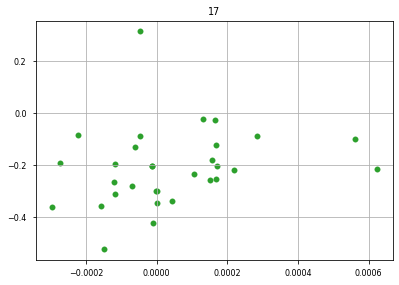

Pearson correlation coefficient: 0.2287240239916463 - P_value: 0.2158515306955775
Spearman correlation coefficient: 0.2842741935483871 - P_value: 0.1211647002115323


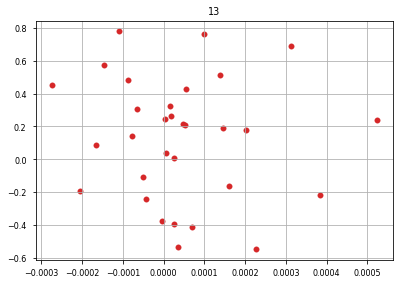

Pearson correlation coefficient: -0.09269657577724316 - P_value: 0.6199130499677221
Spearman correlation coefficient: -0.13588709677419356 - P_value: 0.46607058942998725


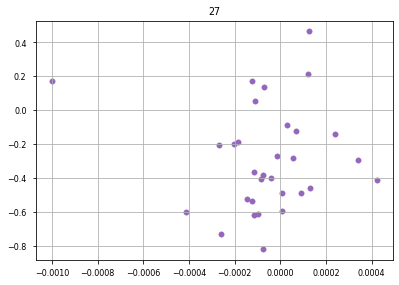

Pearson correlation coefficient: -0.03840356042363762 - P_value: 0.8374857512050806
Spearman correlation coefficient: 0.1653225806451613 - P_value: 0.3741165296942002


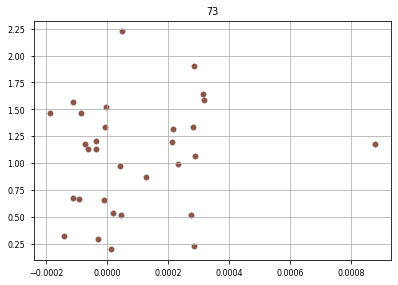

Pearson correlation coefficient: 0.14035339112071266 - P_value: 0.4514013261712654
Spearman correlation coefficient: 0.1282258064516129 - P_value: 0.4918062709476104


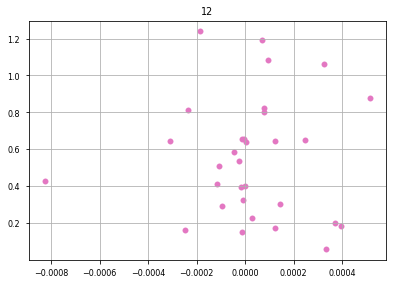

Pearson correlation coefficient: 0.002198758958391626 - P_value: 0.9906337864151185
Spearman correlation coefficient: -0.00806451612903226 - P_value: 0.9656562979054862


In [92]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    eda_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        average_user_eda = df_u['EDA'].mean()
        df_uv = df_u[df_u['video']==video]
        nss_diff = df_uv['NSS_diff'].mean()
        eda = df_uv['EDA'].mean() - average_user_eda
        nss_data.append(nss_diff)
        eda_data.append(eda)
        plt.scatter([eda], [nss_diff], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(eda_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(eda_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## HL NSS vs graded arousal separated videos

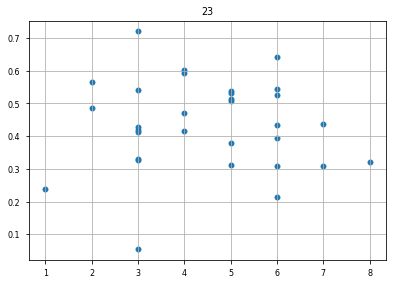

Pearson correlation coefficient: -0.021198264918261236 - P_value: 0.9098805396386541
Spearman correlation coefficient: -0.08323739264779152 - P_value: 0.6561931756370589


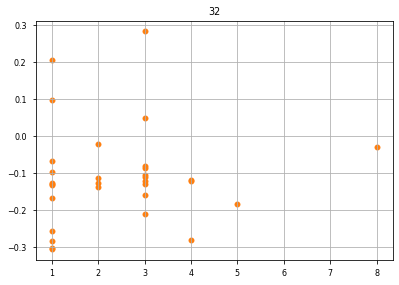

Pearson correlation coefficient: 0.08710043552529828 - P_value: 0.6412777417743162
Spearman correlation coefficient: 0.14676670640610925 - P_value: 0.4307773071806751


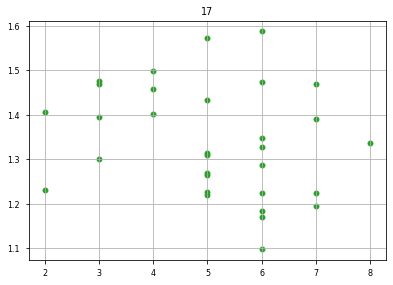

Pearson correlation coefficient: -0.22779229973289514 - P_value: 0.21777890673649355
Spearman correlation coefficient: -0.2764160551892277 - P_value: 0.13225250328374474


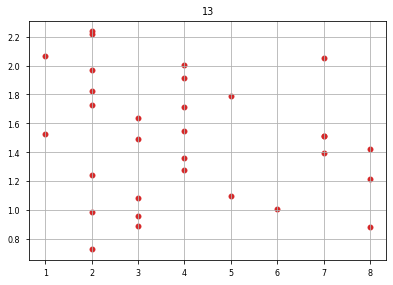

Pearson correlation coefficient: -0.20898114029291026 - P_value: 0.25921204316214236
Spearman correlation coefficient: -0.23761314083906612 - P_value: 0.19804726496952585


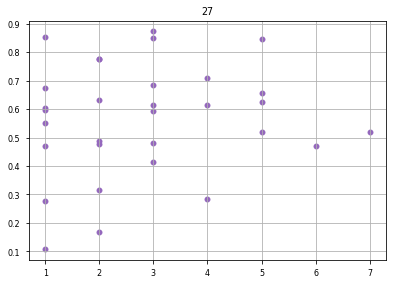

Pearson correlation coefficient: 0.136006357084781 - P_value: 0.46567565831422175
Spearman correlation coefficient: 0.13473800270085884 - P_value: 0.46988483053287755


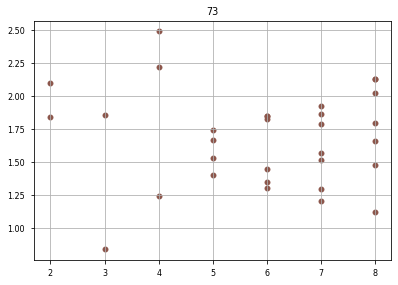

Pearson correlation coefficient: -0.06164298638021369 - P_value: 0.7418359848224183
Spearman correlation coefficient: -0.030751447381684505 - P_value: 0.8695584485262499


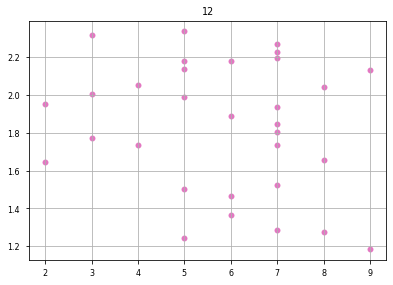

Pearson correlation coefficient: -0.19510746184102665 - P_value: 0.2928813135420957
Spearman correlation coefficient: -0.16484626878387867 - P_value: 0.37551382016413504


In [93]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    aro_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        df_uv = df_u[df_u['video']==video]
        hl_nss = df_uv['HL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(hl_nss)
        aro_data.append(arousal)
        plt.scatter([arousal], [hl_nss], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(aro_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(aro_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## LL NSS vs graded arousal separated videos

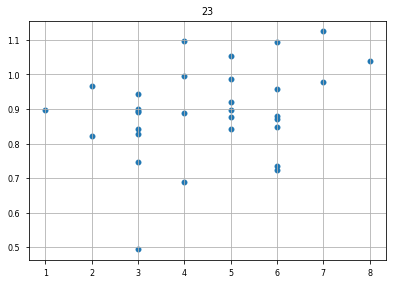

Pearson correlation coefficient: 0.30673907705930165 - P_value: 0.0932682403019143
Spearman correlation coefficient: 0.2614270702419526 - P_value: 0.1554351750344564


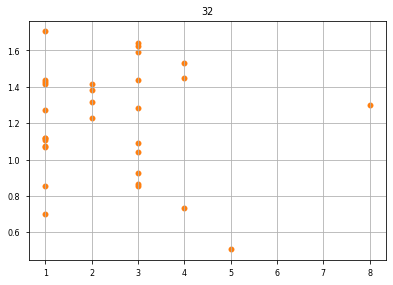

Pearson correlation coefficient: -0.06431627560043444 - P_value: 0.7310431053583801
Spearman correlation coefficient: 0.013342427855100843 - P_value: 0.9432085535939843


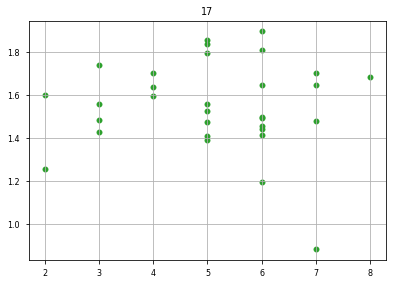

Pearson correlation coefficient: -0.027981580821156052 - P_value: 0.8812209763906327
Spearman correlation coefficient: -0.0020643469394266444 - P_value: 0.9912063284016416


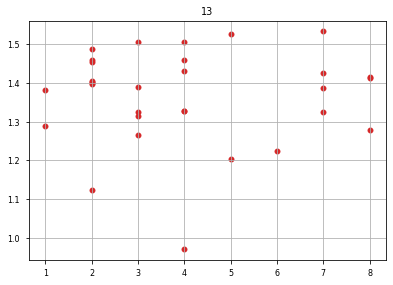

Pearson correlation coefficient: 0.023931528507986726 - P_value: 0.8983170808799699
Spearman correlation coefficient: 0.023761314083906613 - P_value: 0.8990366247690984


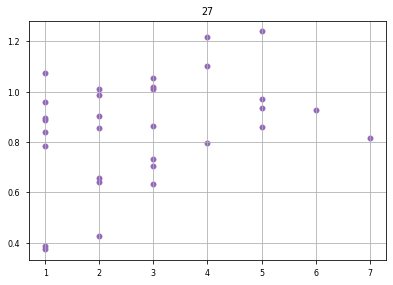

Pearson correlation coefficient: 0.33621134217096926 - P_value: 0.06441915546415163
Spearman correlation coefficient: 0.3018213669063581 - P_value: 0.09891175932393363


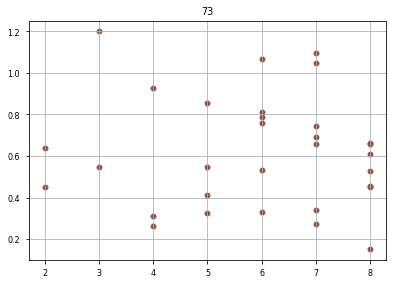

Pearson correlation coefficient: -0.06742404139927471 - P_value: 0.7185593324107548
Spearman correlation coefficient: -0.03874682370092248 - P_value: 0.8360525990506158


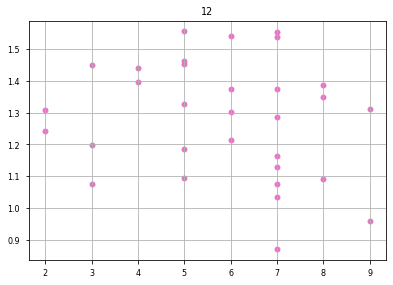

Pearson correlation coefficient: -0.18358990500529465 - P_value: 0.32285125602700004
Spearman correlation coefficient: -0.20220868586814508 - P_value: 0.2753159261814702


In [94]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    aro_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        df_uv = df_u[df_u['video']==video]
        ll_nss = df_uv['LL_NSS'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(ll_nss)
        aro_data.append(arousal)
        plt.scatter([arousal], [ll_nss], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(aro_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(aro_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

## NSS diff vs graded arousal separated videos

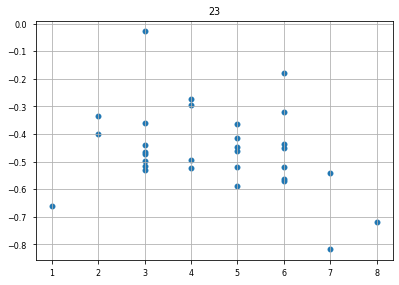

Pearson correlation coefficient: -0.2843478792743095 - P_value: 0.12106409847624475
Spearman correlation coefficient: -0.2698535717198772 - P_value: 0.14206814589238043


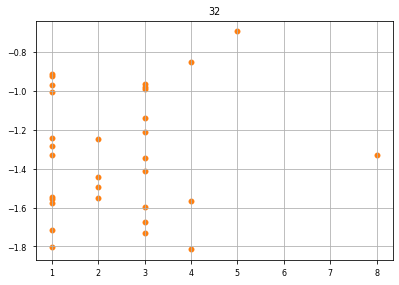

Pearson correlation coefficient: 0.09927757202117096 - P_value: 0.5951729122880507
Spearman correlation coefficient: 0.046169036070031484 - P_value: 0.8051976430279482


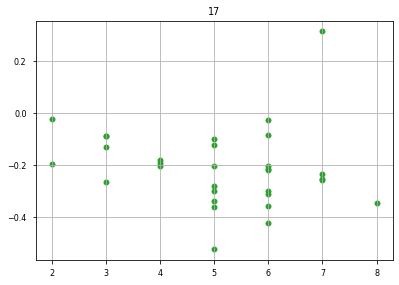

Pearson correlation coefficient: -0.14945155442060096 - P_value: 0.4222997579512779
Spearman correlation coefficient: -0.30841343275034067 - P_value: 0.0914036979721728


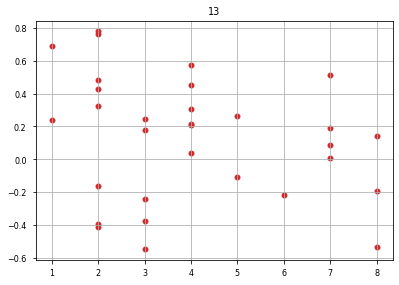

Pearson correlation coefficient: -0.24438861710857296 - P_value: 0.18517873334235585
Spearman correlation coefficient: -0.2703873671616959 - P_value: 0.1412504944071005


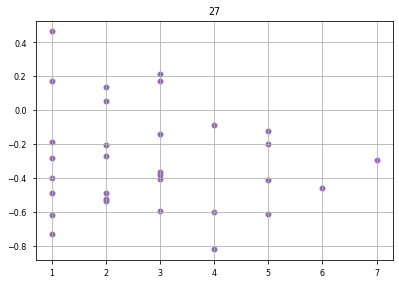

Pearson correlation coefficient: -0.14761084950671258 - P_value: 0.42810185586310817
Spearman correlation coefficient: -0.08076039305617226 - P_value: 0.6658262430495028


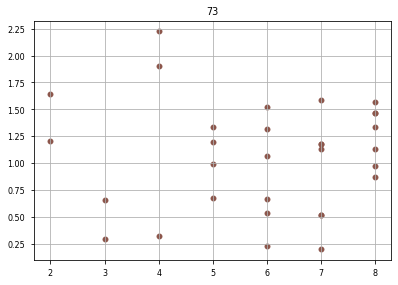

Pearson correlation coefficient: -0.008291492444547278 - P_value: 0.9646902820099845
Spearman correlation coefficient: 0.0225510614132353 - P_value: 0.9041549349679299


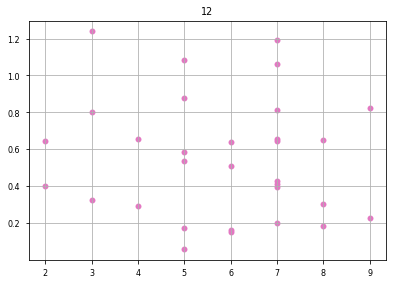

Pearson correlation coefficient: -0.10581772255509506 - P_value: 0.5710190560290981
Spearman correlation coefficient: -0.06897677000172257 - P_value: 0.7123484065962753


In [95]:
for video in df_NSS_150['video'].unique():
    nss_data = []
    aro_data = []
    for user in df_NSS_150['user'].unique():
        df_u = df_NSS_150[df_NSS_150['user']==user]
        df_uv = df_u[df_u['video']==video]
        nss_diff = df_uv['NSS_diff'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(nss_diff)
        aro_data.append(arousal)
        plt.scatter([arousal], [nss_diff], c=[video_colors[video]], label=video)
    plt.title(video)
    plt.show()
    corr, p = pearsonr(aro_data, nss_data)
    print(f'Pearson correlation coefficient: {corr} - P_value: {p}')
    corr, p = spearmanr(aro_data, nss_data)
    print(f'Spearman correlation coefficient: {corr} - P_value: {p}')

In [96]:
user_centered_eda = []

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    user_centered_eda.extend(df_u['EDA'].values - df_u['EDA'].mean())

df_NSS_150['EDA_centered'] = user_centered_eda

In [97]:
plt.close()

## HL NSS vs EDA centered (video average)

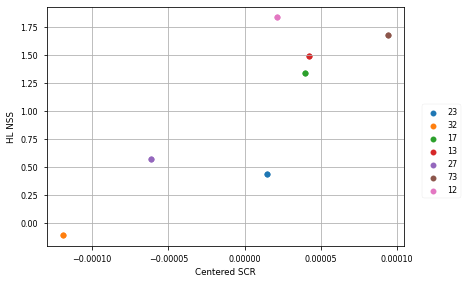

In [98]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    hl_nss = df_v['HL_NSS'].mean()
    eda = df_v['EDA_centered'].mean()
    plt.scatter([eda, eda], [hl_nss, hl_nss], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Centered SCR')
plt.ylabel('HL NSS')
# tikzplotlib.save('fig4b_v0.tex')
plt.show()

## LL NSS vs EDA centered (video average)

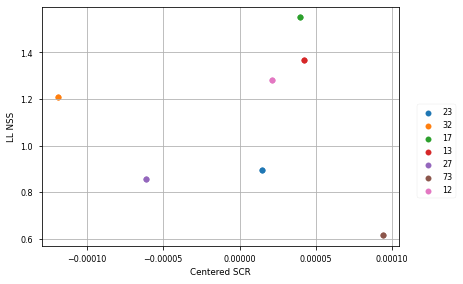

In [99]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    ll_nss = df_v['LL_NSS'].mean()
    eda = df_v['EDA_centered'].mean()
    plt.scatter([eda, eda], [ll_nss, ll_nss], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Centered SCR')
plt.ylabel('LL NSS')
# tikzplotlib.save('fig4c_v0.tex')
plt.show()

## NSS diff vs EDA centered (video average)

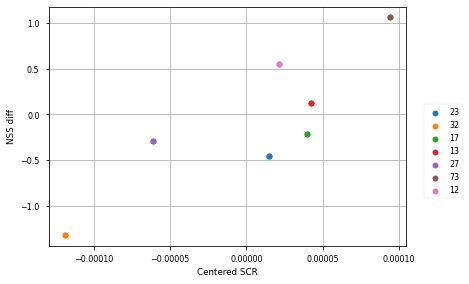

In [100]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    nss_diff = df_v['NSS_diff'].mean()
    eda = df_v['EDA_centered'].mean()
    plt.scatter([eda, eda], [nss_diff, nss_diff], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Centered SCR')
plt.ylabel('NSS diff')
# tikzplotlib.save('fig4a_v0.tex')
plt.show()

## HL NSS vs graded arousal (video average)

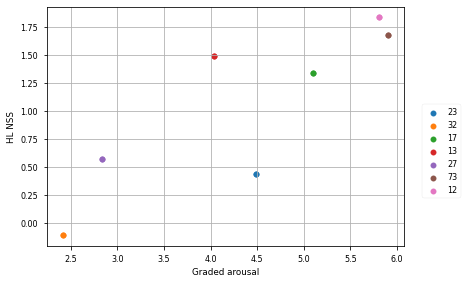

In [101]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    hl_nss = df_v['HL_NSS'].mean()
    arousal = []
    for user in df_NSS_150['user'].unique():
        arousal.append(get_valence_arousal(user, video)[1])
    arousal = np.mean(arousal)
    plt.scatter([arousal, arousal], [hl_nss, hl_nss], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Graded arousal')
plt.ylabel('HL NSS')
# tikzplotlib.save('fig4f_v0.tex')
plt.show()

## LL NSS vs graded arousal (video average)

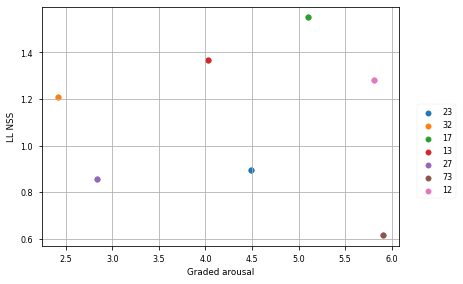

In [102]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    ll_nss = df_v['LL_NSS'].mean()
    arousal = []
    for user in df_NSS_150['user'].unique():
        arousal.append(get_valence_arousal(user, video)[1])
    arousal = np.mean(arousal)
    plt.scatter([arousal, arousal], [ll_nss, ll_nss], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Graded arousal')
plt.ylabel('LL NSS')
# tikzplotlib.save('fig4g_v0.tex')
plt.show()

## NSS diff vs graded arousal (video average)

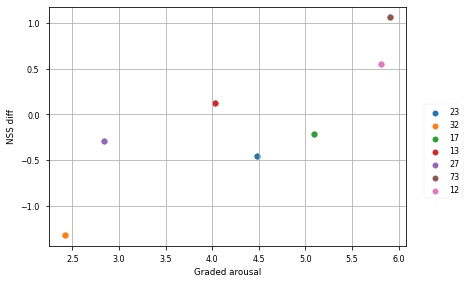

In [103]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    nss_diff = df_v['NSS_diff'].mean()
    arousal = []
    for user in df_NSS_150['user'].unique():
        arousal.append(get_valence_arousal(user, video)[1])
    arousal = np.mean(arousal)
    plt.scatter([arousal, arousal], [nss_diff, nss_diff], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Graded arousal')
plt.ylabel('NSS diff')
# tikzplotlib.save('fig4e_v0.tex')
plt.show()

## HL SUM (pix in obj) vs dataset arousal

In [104]:
dataset_arousal = {'12': 4.6, '13': 4.08, '17': 5, '23': 3.2, '27': 1.6, '32': 1.57, '73': 6.18}

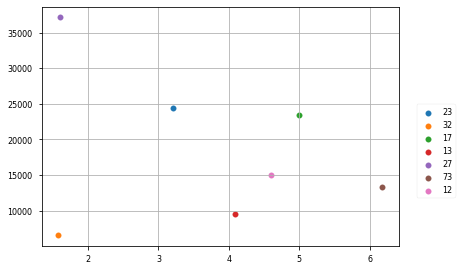

In [105]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    hl_sum = df_v['hl_sum'].mean()
    arousal = dataset_arousal[video]
    plt.scatter([arousal], [hl_sum], c=[video_colors[video]], label=video)
plt.legend(loc=(1.05, 0.2))
plt.show()

## HL SUM (pix in obj) vs graded arousal

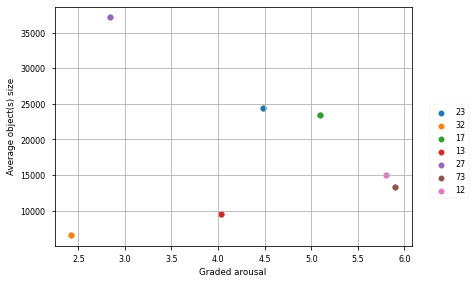

In [106]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    hl_sum = df_v['hl_sum'].mean()
    arousal = []
    for user in df_NSS_150['user'].unique():
        arousal.append(get_valence_arousal(user, video)[1])
    arousal = np.mean(arousal)
    plt.scatter([arousal, arousal], [hl_sum, hl_sum], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Graded arousal')
plt.ylabel('Average object(s) size')
# tikzplotlib.save('fig4h_v0.tex')
plt.show()

## HL SUM (pix in obj) vs EDA centered

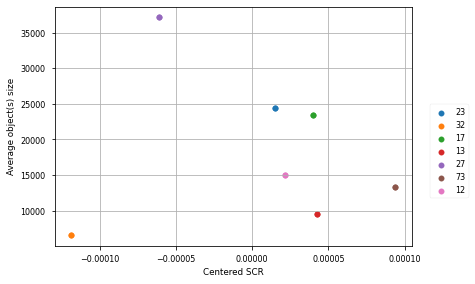

In [107]:
for video in df_NSS_150['video'].unique():
    df_v = df_NSS_150[df_NSS_150['video']==video]
    hl_sum = df_v['hl_sum'].mean()
    eda = df_v['EDA_centered'].mean()
    plt.scatter([eda, eda], [hl_sum, hl_sum], color=video_colors[video], label=video)
plt.legend(loc=(1.05, 0.2))
plt.xlabel('Centered SCR')
plt.ylabel('Average object(s) size')
# tikzplotlib.save('fig4d_v0.tex')
plt.show()

## NSS diff vs EDA centered

y=854.4267642642557x-0.08048489866407917


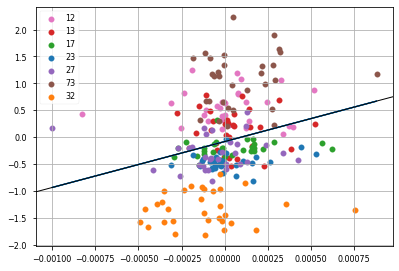

In [108]:
nss_data = []
eda_data = []
nss_plot = {}
eda_plot = {}

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    average_user_eda = df_u['EDA'].mean()
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        eda = df_v['EDA'].mean() - average_user_eda
        nss_data.append(nss_diff)
        eda_data.append(eda)
        try:
            nss_plot[video].append(nss_diff)
            eda_plot[video].append(eda)
        except KeyError:
            nss_plot[video] = [nss_diff]
            eda_plot[video] = [eda]

nss_data = np.array(nss_data)
eda_data = np.array(eda_data)
        
#linear model
x = eda_data
y = nss_data
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x + b)
if b < 0:
    print(f'y={a}x-{-b}')
else:
    print(f'y={a}x+{b}')


for video in ['12', '13', '17', '23', '27', '73', '32']:
    plt.scatter(eda_plot[video], nss_plot[video], color=video_colors[video], label=video)

plt.axline(xy1=[0, b], slope=a, c='black', lw=1)

plt.legend()
plt.show()

## NSS diff vs graded arousal

y=0.14631926795893957x-0.7157571174220362


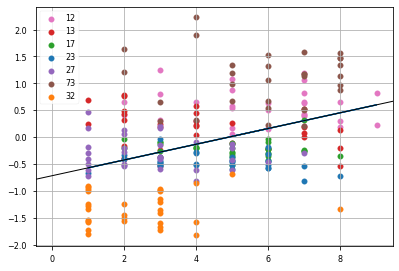

In [109]:
nss_data = []
arousal_data = []
nss_plot = {}
arousal_plot = {}

for user in df_NSS_150['user'].unique():
    df_u = df_NSS_150[df_NSS_150['user']==user]
    for video in df_u['video'].unique():
        df_v = df_u[df_u['video']==video]
        nss_diff = df_v['NSS_diff'].mean()
        _, arousal = get_valence_arousal(user, video)
        nss_data.append(nss_diff)
        arousal_data.append(arousal)
        try:
            nss_plot[video].append(nss_diff)
            arousal_plot[video].append(arousal)
        except KeyError:
            nss_plot[video] = [nss_diff]
            arousal_plot[video] = [arousal]

nss_data = np.array(nss_data)
arousal_data = np.array(arousal_data)
        
#linear model
x = arousal_data
y = nss_data
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x + b)
if b < 0:
    print(f'y={a}x-{-b}')
else:
    print(f'y={a}x+{b}')


for video in ['12', '13', '17', '23', '27', '73', '32']:
    plt.scatter(arousal_plot[video], nss_plot[video], color=video_colors[video], label=video)

plt.axline(xy1=[0, b], slope=a, c='black', lw=1)

plt.legend()
plt.show()

## Valence-arousal plane distance dataset vs graded

In [110]:
dataset_arousal = {'12': 4.6, '13': 4.08, '17': 5, '23': 3.2, '27': 1.6, '32': 1.57, '73': 6.18}
dataset_valence = {'12': 7, '13': 4.92, '17': 5.22, '23': 7.2, '27': 6, '32': 6.57, '73': 6.27}

videos = sorted(df_NSS_150['video'].unique())
users = sorted(df_NSS_150['user'].unique())

graded_arousal = {}
graded_valence = {}

for video in videos:
    for user in users:
        valence, arousal = get_valence_arousal(user, video)
        try:
            graded_arousal[video].append(arousal)
            graded_valence[video].append(valence)
        except KeyError:
            graded_arousal[video] = [arousal]
            graded_valence[video] = [valence]

distances = {}
            
for video in videos:
    graded_arousal[video] = np.mean(graded_arousal[video])
    graded_valence[video] = np.mean(graded_valence[video])
    
    distances[video] = np.sqrt((graded_arousal[video] - dataset_arousal[video]) ** 2 + (graded_valence[video] - dataset_valence[video]) ** 2)

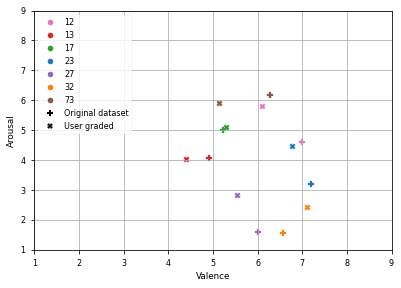

In [111]:
for video in videos:
    plt.scatter([dataset_valence[video]], [dataset_arousal[video]], c=[video_colors[video]], marker='P')
    plt.scatter([graded_valence[video]], [graded_arousal[video]], c=[video_colors[video]], marker='X')
    
plt.xlim(1, 9)
plt.ylim(1, 9)
plt.xlabel('Valence')
plt.ylabel('Arousal')

markers=['P', 'X']
colors = [video_colors[video] for video in videos]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles = [f("o", colors[i]) for i in range(7)]
handles += [f(markers[i], "k") for i in range(2)]

labels = videos + ['Original dataset', 'User graded']
plt.legend(handles, labels, loc='upper left')

plt.show()

In [112]:
for key, value in distances.items():
    print(f'Video {key} valence-arousal distance between user graded and original dataset: {value}')
print(f'Mean distance: {np.mean(list(distances.values()))}')
print(f'Median distance: {np.median(list(distances.values()))}')

Video 12 valence-arousal distance between user graded and original dataset: 1.507097326557566
Video 13 valence-arousal distance between user graded and original dataset: 0.5350375131508709
Video 17 valence-arousal distance between user graded and original dataset: 0.11962654339876198
Video 23 valence-arousal distance between user graded and original dataset: 1.352640305493587
Video 27 valence-arousal distance between user graded and original dataset: 1.3184672461962805
Video 32 valence-arousal distance between user graded and original dataset: 0.9994471937166542
Video 73 valence-arousal distance between user graded and original dataset: 1.1740576401317424
Mean distance: 1.0009105383779233
Median distance: 1.1740576401317424
